### Time Series Analysis
By Matthew Heino

### Purpose:
This is a Jupyter Notebook for the D213 assessment for Advanced Data Analysis. This notebook will not be the only submission for this assessment.  There will be some additional files:

- The cleaned dataset (section C5) and the training and test (section D1) will be saved to CSVs files that will acccompany this submission.
- A PDF, the executed Jupyter Notebook, contains all the output from this notebook in PDF form. 
- This assessment does not consist of a Panopto video.

Concepts that will be explored in this notebook will be:

- Creation of a time series model.
- Data preparation 
- Data transformation, transforming data into a form that can be used for time series model.

**Note:** Code that has references uses the APA citation can be found in sections G and H in this Jupyter Notebook as well as the Word document.

**Note:** The original code was produced in Spyder ver. 5.3.3 and copied into this notebook.  This original Python script will not be accompanying this submission, but can made available upon reques

# Background

The file used in the assessment contains time series data that was gathered time series data for the university hospital. The data is data for the revenue for the hospital for the first two years of operation. The file is composed of two columns:
1. Day - a numeric day 
2. Revenue - the revenue is in millions of dollars.

There are 731 rows in the dataset. This number of columns accounts for the first month of data where no revenue was recorded. 

The data is found in the following file:
- **medical_time_series.csv**

This is the file that will contain the raw data that is used for time series analysis. 

**Note:**  This file must be in the same directory if you plan to run this notebook.

# Part I: Research Question
This section will discuss the research question that is to be answered using the time series data that is provided by the university.  This section will discuss the goals of the data analysis.
This section will discuss the research question that is to be answered using the time series data that is provided by the university.  

## A1. Research Question.
The question that can be answered using the times series data provided by the university is the following:
- Is it possible to predict or forecast the daily revenues for the university hospital accurately and how do these predictions compare to what is observed? 

## A2. Research Goals and Objectives

Data analysis goal is to effectively predict the daily revenue of the university hospital. This goal is to be able to develop a model that can accurately predict future revenue for the hospital.

## Pre-assessment tasks:
        
        1. Read the data from the CSV.
        2. Get a feel for what the data contains. 
        3. Print some information about the dataframe. 

# Part II: Justification of Methodology

This section will discuss the assumptions that are inherent in time series data modeling. 

## B.  Assumptions of Time Series Data Modeling.

There are a few assumptions that are associated with time series data modeling. The assumptions are the following:

1. There must be stationarity in the time series.
2. The time series data must not contain any outliers.
3. The data is univariate, reflecting a single variable to be modeled.
4. Past data points are indicative of the behavior of future data points.

In [1]:
# Import the appropriate libraries

import matplotlib.dates as mdt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sts

import warnings

from math import sqrt
from pmdarima import auto_arima
from scipy import signal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Functions used in the assessment.

**NOTE:** The '#' is to make it easier to find the beginning and the end of each of the functions. 

In [3]:
#Function Definitions Begin Here. #############################################

def calc_dickey_fuller(rev_array : np.array) -> tuple:
    
    """ Method to calculate Dickey_Fuller values
    
    Parameters:
        rev_array (np.array): Array of revenue values.
     
    Returns:
        results_adfuller (tuple): Tuple with the results of the ADF 
        calculation.
        
    """
    
    results_adfuller = sts.adfuller(rev_array)

    return results_adfuller

###############################################################################

def create_spectral_plt(dataframe, column, ax, i:int, graph_title:str
                        , legend_text:str) -> plt:
# (matplotlib.pyplot.semilogy — Matplotlib 3.8.2 Documentation, n.d.)
# (SciPy.Signal.Periodogram — SciPY V1.12.0 Manual, n.d.)

    """ Method to create a spectral density graph. 
    
    Parameters:
        dataframe (dataframe): Dataframe with the data.
        column(str): column name
        ax(): position
        i(int): index for the graph item
        graph_title(str): Title for the graph.
        legend_text:str Legend information
     
    Returns:
       None
        
    """
    
    f, Pxx = signal.periodogram(dataframe[column])
    ax[i].semilogy(f, Pxx, label=legend_text)
    ax[i].set_title(graph_title)
    ax[i].legend()
    
    return ax[i]

#########################################################################################

def print_results_tuple(result_tuple: tuple):
    
    """ Method to print Dickey_Fuller values
    
    Parameters:
        result_tuple (tuple): Array of revenue values.
     
    Returns:
       None
        
    """
    
    print("\nADF Statistic: \t %f" % result_tuple[0])
    print("p-value: \t %f" % result_tuple[1])
    print("Critical Values: \n")
    
    # Interate through the values in the remaining parts of the tuple.
    for key, value in result_tuple[4].items():
        print("\t%s: %.3f" % (key, value))

###############################################################################

def read_series_data(file_name : str, index='Day', new_index='Date'
                     , start_date_str=None
                     , freq='D') -> pd.DataFrame():
    
    """  Create a dataframe that contains the time series data that has 
         been read from a file.
         
         Parameters:
         -----------------
         file(str):             File name of the time series.
         index(str):            The initial index of the column.
         new_index(str):        New index name for the dataframe.
         start_date_str(str):   The start date for the dataframe.
         freq(char):            Frequncy ofthe time series.
         
         
         Returns:
         -----------------
         time_series(DataFrame):  A pandas dataframe with the time series data.
    
    """
    
    # Read the data from the CSV file
    time_series_df = pd.read_csv(file_name)
    
    
    # Convert the start date from a string to a TimeStamp.
    start_date = pd.to_datetime(start_date_str)
    
    # Convert the 'Day' column the appropriate format.
    time_series_df[index] = pd.to_timedelta(time_series_df[index] - 1
                                            , unit=freq) + start_date
    
    # Rename the column to reflect more accurately reflect the contents 
    # and the format (yyyy-mm-dd). 
    time_series_df.rename(columns={'Day': 'Date'}, inplace=True)
    
    # Reset the index for the dataframe to the Date column.
    time_series_df.set_index('Date', inplace=True)
    
    
    return time_series_df

###############################################################################  

def rolling_mean(days=30):
    
    """ Create the rolling mean for the data in the dataframe.
    
    Parameters
    ----------
    
    days (int):           Days back to compute
                                
    Retuns:
    --------
    
    None:
    
    """
    time_series_df['rolling_mean'] = time_series_df['Revenue'].rolling(window=days).mean()

###############################################################################


def rolling_std(days=30):
    
    """ Create the rolling standard deviation for the data in the dataframe.
    
    Parameters
    ----------
    
    days (int):           Days back to compute
    
                                
    Retuns:
    --------
    
    None:
    
    """
    time_series_df['rolling_std'] = time_series_df['Revenue'].rolling(window=days).std()

###############################################################################

def test_stationarity(p_value : float, critical=0.05):
    
    """ Method to test for stationarity
    
    Parameters:
        p_value (float): The resultant p-value.
     
    Returns:
       None
        
    """
    
    if p_value <= critical:
        print("\nReject the null hypothesis H0, the data is stationary.")
    else:
        print("\nAccept the null hypothesis, the data is non-stationary. ") 
###############################################################################

# Part III: Data Preparation
This section will discuss the data cleaning process as it pertains to the data that has been provided. 

## C1. Visualization of the Time Series

To plot the data as a time series graph.  Utilizing this method will make it easier to proceed with the other sections of this assessment. The current format of the data has the start day as 1 and the ending data as 731.  These values could be plotted as is, but this change of the index to the data is required for other sections of the assessment.  It makes logical sense to handle it here. 

There was no indication as to what the start date should be so the date is set to '2020-01-01'.  It is believed that this should be an issue going forward with other sections of the assessment. The start date is open to interpretation and this start date seems the most logical.

The "Day" column will then be converted to the date format. The method **datetime** will compute the days using the start date as the starting point. Arguments for this method are:

- dataframe column  = 'Day'
- unit = 'D' - for the unit.
- start_date - the start date 

In [4]:
# Read in the file and create the dataframe. **********************************

time_series_df = read_series_data(file_name='medical_time_series .csv', index='Day', freq='D', start_date_str='2020-01-01')

#### Print some information and a summary of the newly created dataframe.

View some information about what is contained in the dataframe. 

- View the data types of the columns.
- Review the information in the columns.

In [5]:
#time_series_df.info()
#time_series_df.shape
#time_series_df.sample(3)


In [6]:
print("Sample: \n", time_series_df.sample(5, random_state=247))

Sample: 
               Revenue
Date                 
2021-11-17  15.976478
2021-07-06  15.065666
2021-11-11  17.326767
2021-05-20  20.395615
2020-07-02  11.214569


Create the rolling average for the graph to look at the mean and standard dviation as they evolve over time.

In [7]:
# Calc the rolling mean. 
rolling_mean(days=5)

# Calc the rolling standard deviation. 
rolling_std(days=5)

In [8]:
#time_series_df.info()

time_series_df.sample(3)

Revenue  rolling_mean  rolling_std
Date                                            
2020-01-27  -4.172912     -3.441502     0.820370
2020-05-29  10.826875     10.713950     0.136244
2021-05-26  21.450867     21.578637     0.321199

Create the visualization to show the time series data.  The graph below shows the time series data after the day is converted to a date format. The method used was to **polyfit** and **polyld** methods.  

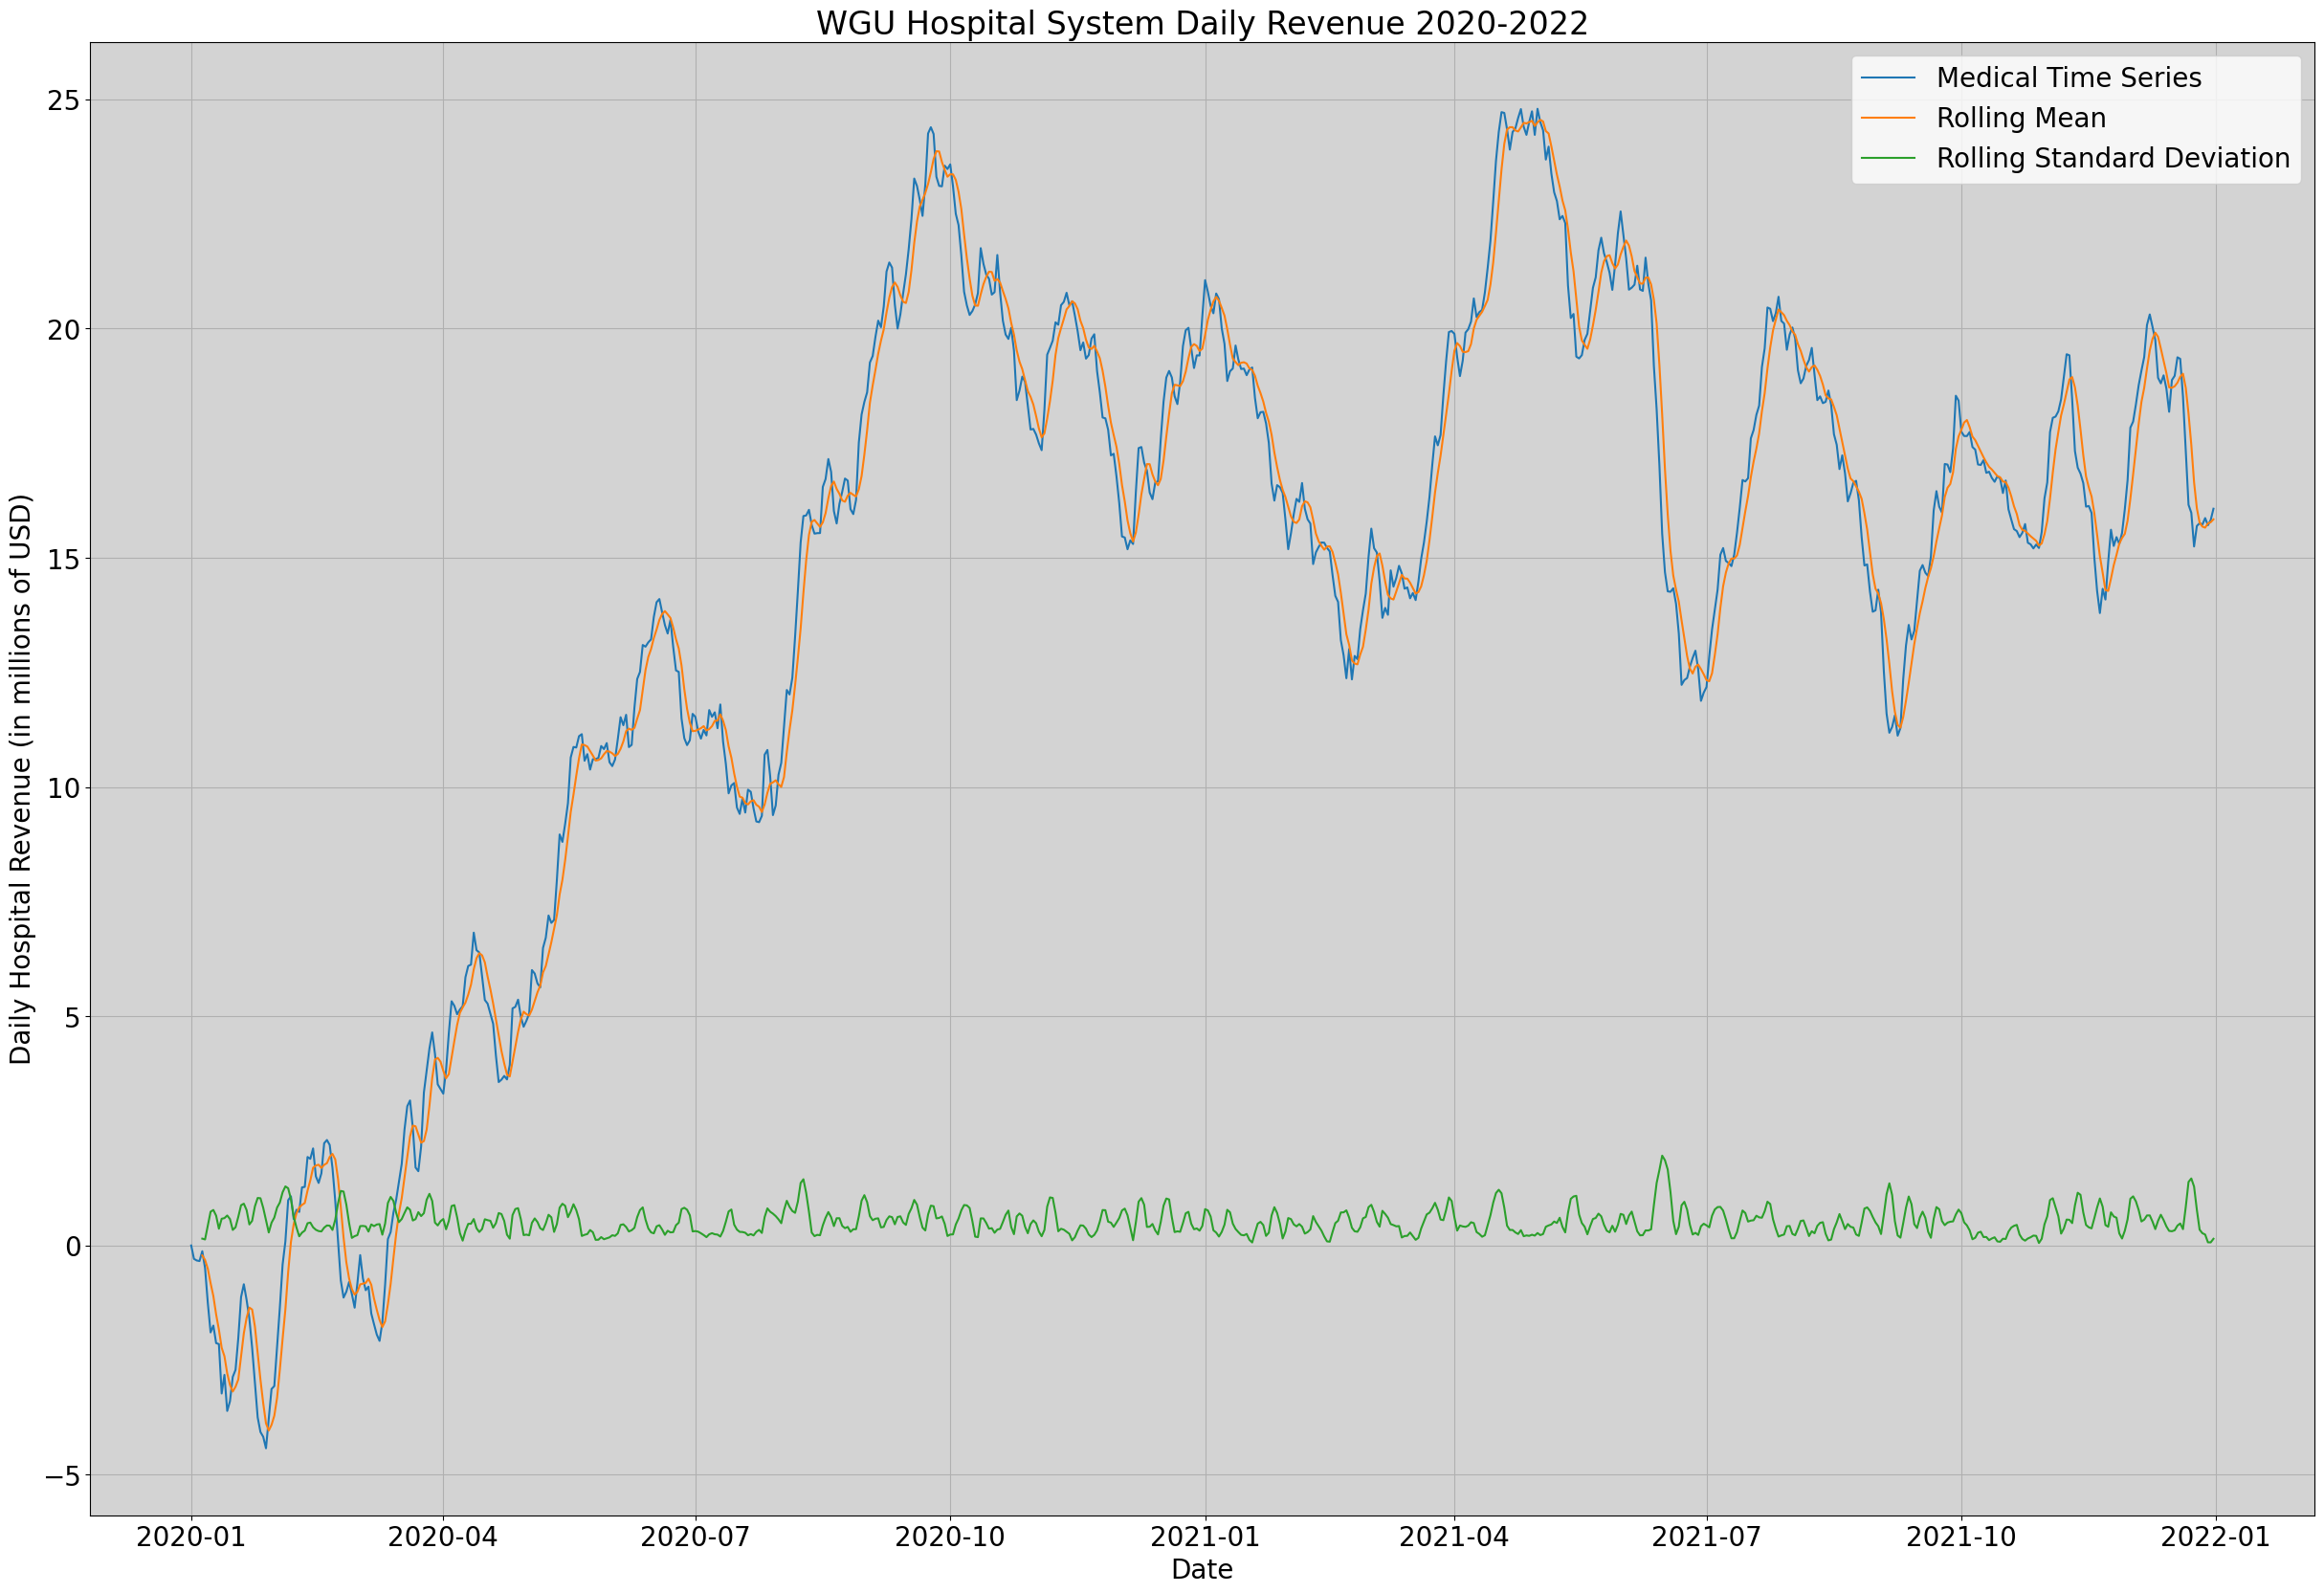

In [9]:
plt.figure(figsize=[30,20])

plt.rcParams.update({'font.size': 20})

ax = plt.axes()

# Add labels to the graph 
plt.title("WGU Hospital System Daily Revenue 2020-2022")
plt.xlabel("Date")
plt.ylabel("Daily Hospital Revenue (in millions of USD)")
ax.set_facecolor('lightgray')

# Plot the time series data.
plt.plot(time_series_df)

# Create the trendline for the data. 
# Convert datetime objects to Matplotlib dates. 
# (matplotlib.dates — Matplotlib 3.8.2 Documentation, n.d.)

x = mdt.date2num(time_series_df.index)
y = time_series_df.Revenue
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

plt.legend(['Medical Time Series', 'Rolling Mean', 'Rolling Standard Deviation'])
plt.grid()

# Show the plot.
plt.show() 

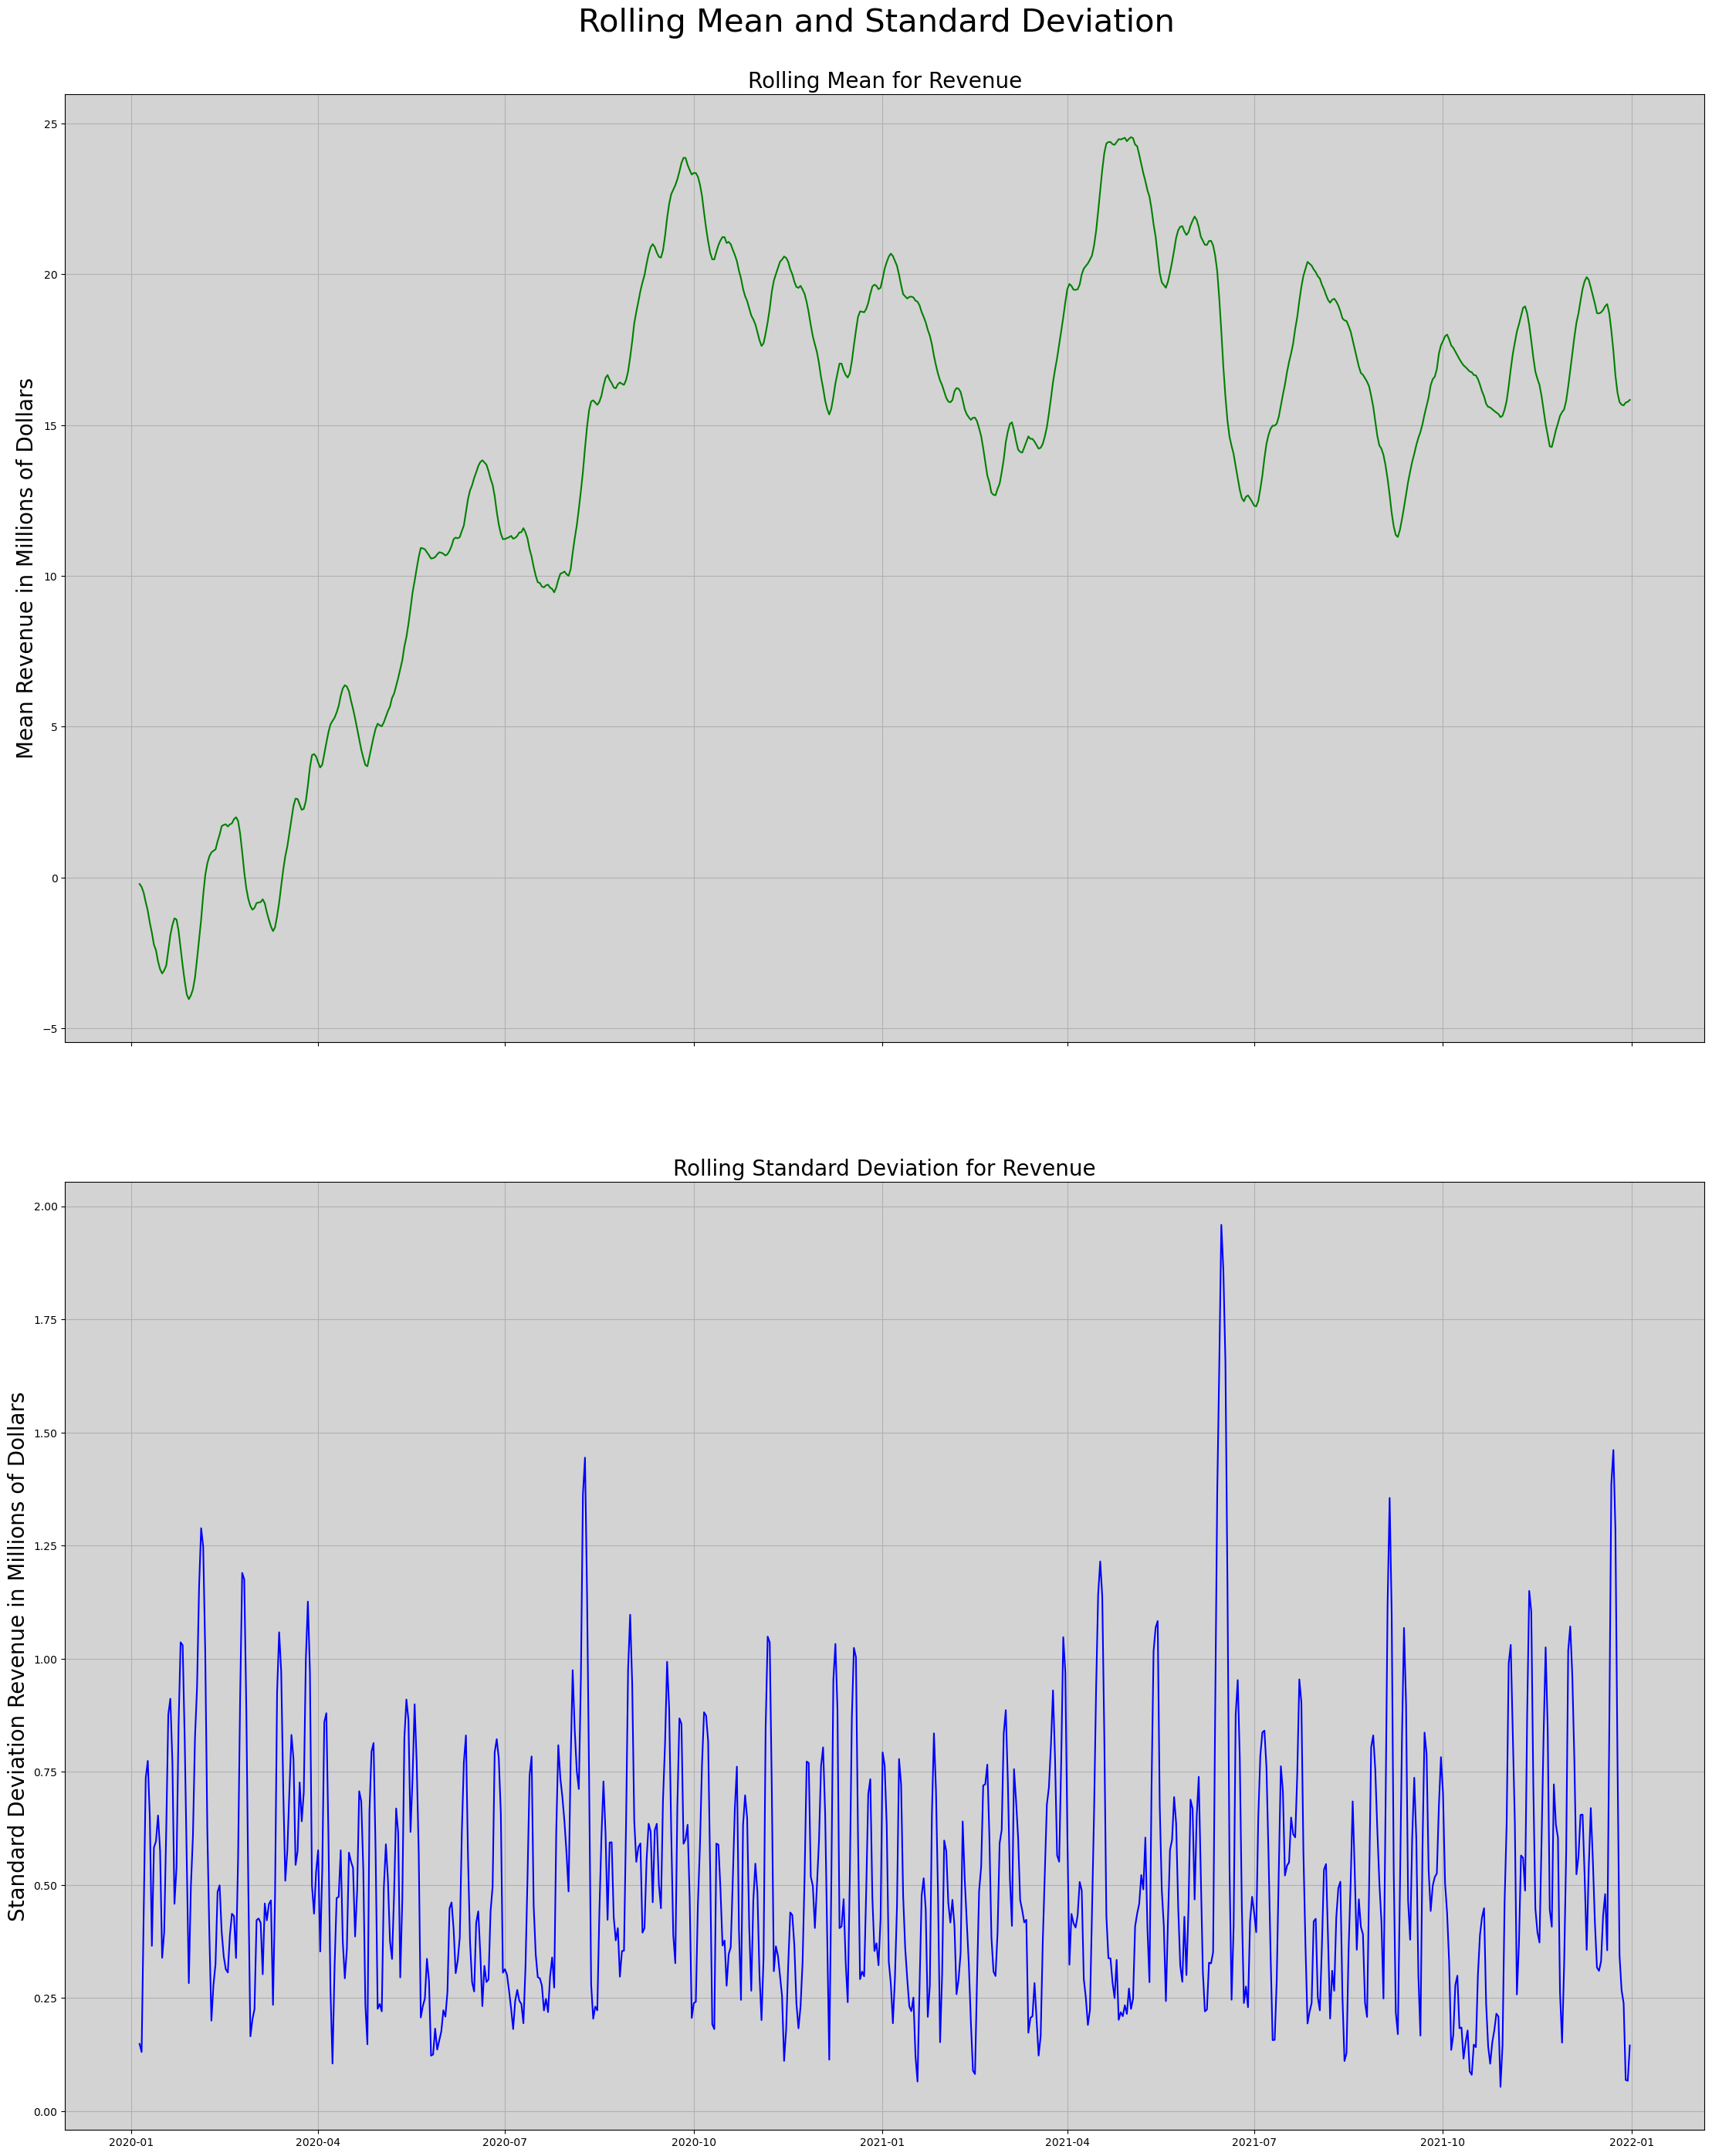

In [10]:
# Reset the plot parameters to show the plot properly.
plt.rcdefaults()

x = pd.Series(time_series_df.index.values)
x2 = pd.Series(range(time_series_df.shape[0]))


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(25 ,30), sharex=True, sharey=False)
fig.tight_layout(pad=12.0)
fig.suptitle('Rolling Mean and Standard Deviation', fontsize=30)

ax1.set_facecolor('lightgray')
ax1.set_title("Rolling Mean for Revenue",fontsize=20)
ax1.set_ylabel('Mean Revenue in Millions of Dollars', fontsize=20)
ax1.grid()

ax2.set_title("Rolling Standard Deviation for Revenue", fontsize=20)
ax2.set_ylabel('Standard Deviation Revenue in Millions of Dollars', fontsize=20)
ax2.grid()
ax1.set_facecolor('lightgray')


ax1.plot(x, time_series_df['rolling_mean'], color='green')
ax2.plot(x, time_series_df['rolling_std'], color='blue')
ax2.set_facecolor('lightgray')


## C2.Description of Time Step Formatting

Reviewing the graph there is a trend in the amount of revenue that the hospital experienced. In the last approximately five months (7-2021 to 1-2022) of the data set the revenue in this timeframe seems to hover around $15 million.  The trend during this period does not trend in the same manner as the previous months.  **More information can be found in the accompanying Word document.**

## C3. Evaluation of Stationarity

To proceed with time series analysis we need to examine the data set for stationarity.  We need data that does not exhibit trends or seasonality.  If the dataset exhibits these trends then we must render the data in a matter so the data does not exhibit this phenomena. The code below clearly shows that the data is non-stationary.

In [11]:
# Call the function to calculate Dickey-Fuller and output the results.
results = calc_dickey_fuller(time_series_df['Revenue'].values)

Using the result from the ADF calculation check to see if the data is stationary by looking at the critical value relative to the p-value.  The critical value will be 0.05.

In [12]:
# Print the results.
print_results_tuple(results)


ADF Statistic: 	 -2.218319
p-value: 	 0.199664
Critical Values: 

	1%: -3.439
	5%: -2.866
	10%: -2.569


Based on the results of the previous calculation the data is **not** stationary. We will need to employ a method to create a stationary data set.  This method will employ the **diff()** function. It will be prudent to drop the row that had no data associated with it.  This was the first day the observations started being recorded. 

In [13]:
# Test for the p-value
test_stationarity(results[1])


Accept the null hypothesis, the data is non-stationary. 


In [14]:
med_stationary_df = time_series_df.diff(periods=1, axis=0).dropna()

In [15]:
results = calc_dickey_fuller(med_stationary_df['Revenue'].values)


In [16]:
# Print the results.
print_results_tuple(results)


ADF Statistic: 	 -17.315500
p-value: 	 0.000000
Critical Values: 

	1%: -3.439
	5%: -2.866
	10%: -2.569


In [17]:
# Test for the p-value
test_stationarity(results[1])


Reject the null hypothesis H0, the data is stationary.


### Plot the transformed data.

To visualize the data for later discussion in subsequent sections of the assessment.

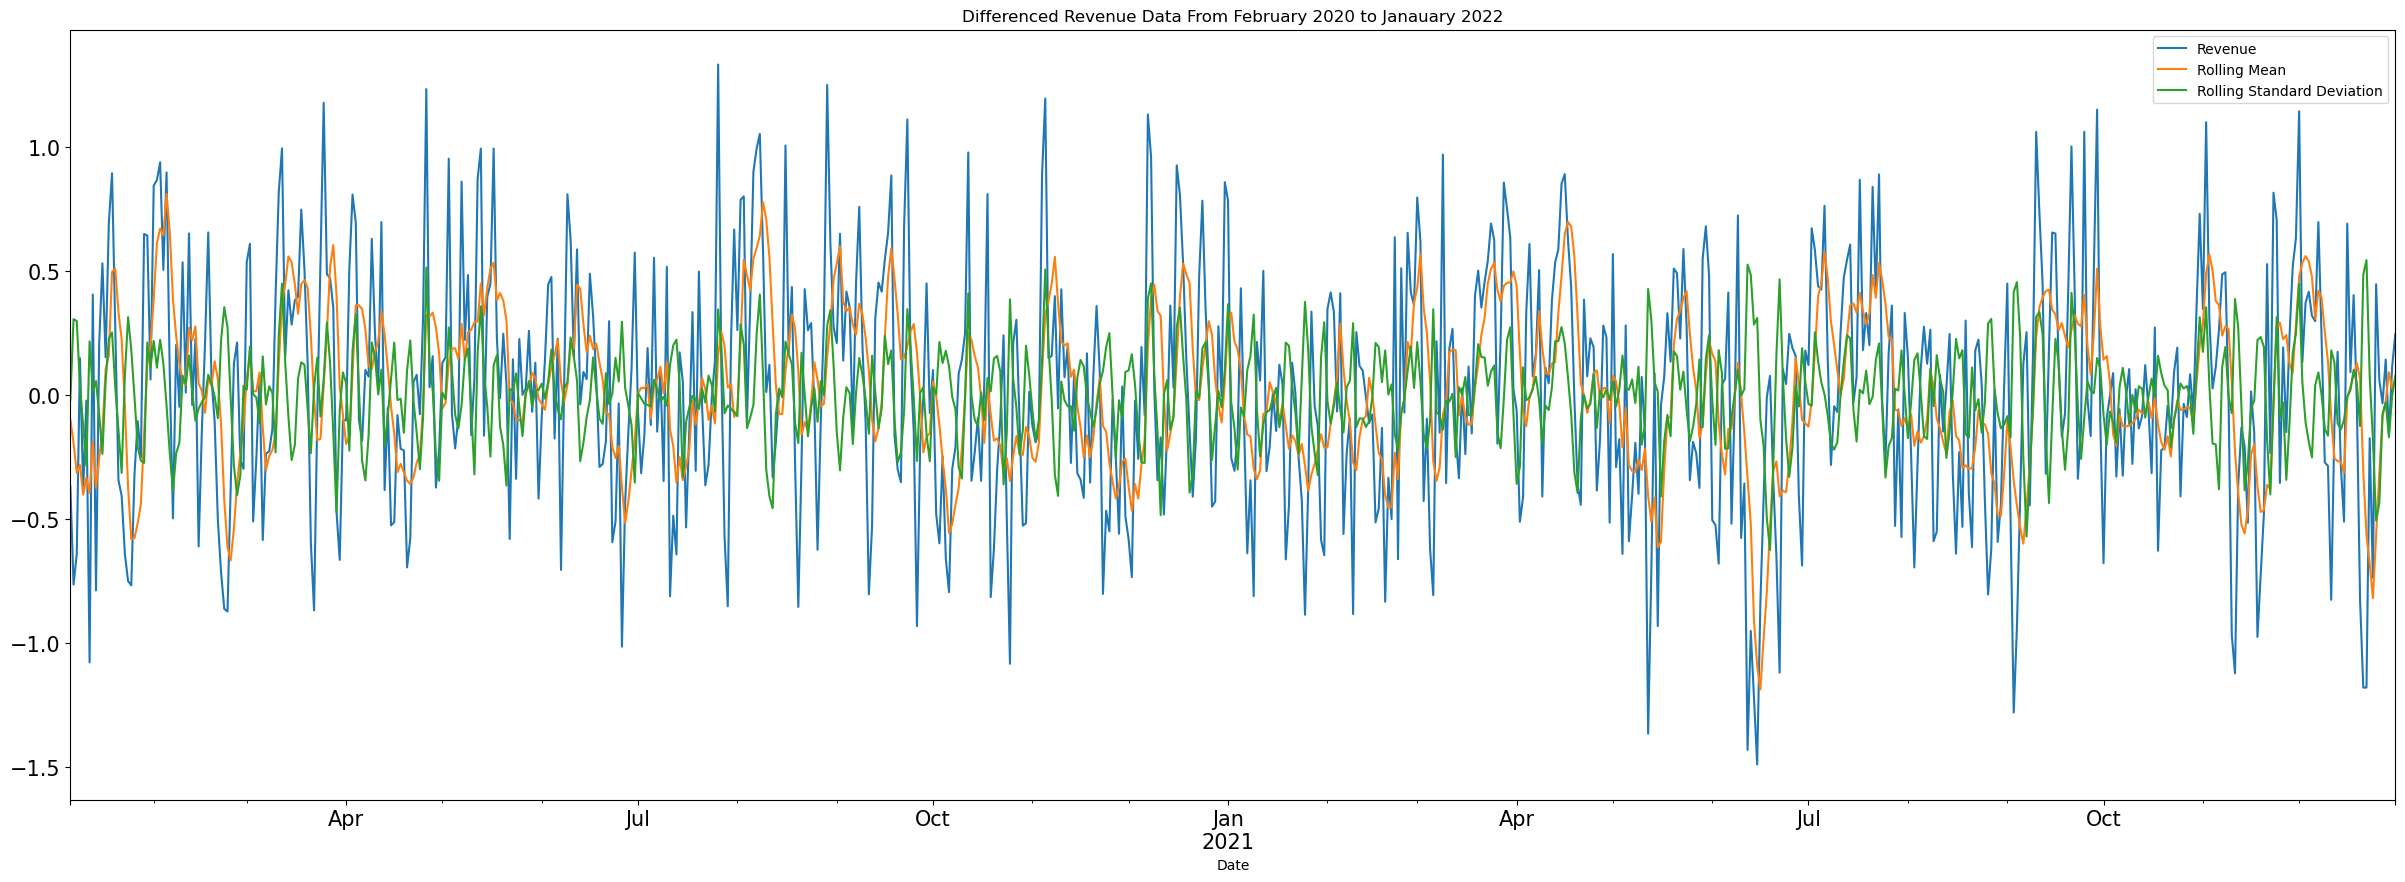

In [18]:
# Plot the transformed data.
med_stationary_df['Revenue'].plot(figsize=[30,10], fontsize=15
                                  ,  title="Differenced  Revenue Data")
med_stationary_df['rolling_mean'].plot(figsize=[30,10]
                                       ,title="Differenced Revenue Data From February 2020 to Janauary 2022")

med_stationary_df['rolling_std'].plot(figsize=[30,10]
                                       ,title="Differenced Revenue Data From February 2020 to Janauary 2022")

plt.legend(['Revenue','Rolling Mean', 'Rolling Standard Deviation'])

## C4. Steps Used to Clean the Data

The steps that were undertaken can be found in the accompanying Word document.

## C5. Copy of the Cleaned Data

Copy of the cleaned data can be found in this file:

- **Heino D213 Task Stationary.csv**

The data that will be exported to the CSV file is the stationary data.  The reason for this is that this data is now in a state that can be used for time series analysis.  

The training and test data will be saved to files in the following section D1.  It was more logical to accompanish the training task in this later section.

In [19]:
# Ouput the stationary dataset to a CSV file for submission.

med_stationary_df.to_csv('Heino D213 Task Stationary.csv')

# Part IV: Identification and Analysis

In this section there will be a discussion of the following:
- Any presence of a seasonal component.
- Identification of trends within the data.
- Review the autocorrelation function.
- Create the spectral density graphs.
- Create the decomposed time series graphs.

There will be an identification and discussion of an autoregressive integrated moving average (ARIMA). A forecasting will be attempted using the model that has been created.  Any calculation will also be discussed and presented in this section.

### 1.  Create the training and test set for the model.

The stationary data has been split into 80% training and 20% testing sets. Shuffle parameter has been set to False to keep the data series intact.

**Note:** Both the test_size and train_size have been set.  This is more for future reference and only one of these parameters really needs to be set.

In [20]:
# Create the train and test set.
# Do not shuffle to keep the series intact.
#train, test = train_test_split(med_stationary_df, test_size=0.2, train_size=.80
 #                              , shuffle=False, random_state=247)
    
train_df = time_series_df.iloc[ : -30]
test_df = time_series_df.iloc[-32 : ]

In [21]:
#test_df.info()
#train_df.info()

In [22]:
train_df.sample(5, random_state=247)

Revenue  rolling_mean  rolling_std
Date                                            
2020-07-29   9.386163     10.101424     0.693833
2021-10-08  17.023974     17.314984     0.299619
2021-05-14  20.317481     21.248243     1.068726
2021-11-30  16.692944     15.808630     0.570821
2020-04-09   5.850377      5.296913     0.318088

#### Output the train and test set to the CSV files. 

Copy of the test and trainig data can be found in these files:

- **Heino D213 Task1 Train.csv**
- **Heino D213 Task1 Test.csv**

The data that will be exported to the CSV file is the testand train data.

In [23]:
# Output the train and test data to CSV files.
train_df.to_csv('Heino D213 Task1 Train.csv')

test_df.to_csv('Heino D213 Task1 Test.csv')

### 2. Check for seasonality.

In this section, there will be a check for the seasonality of the data. This will be accomplished by looking at a visualization of the differenced data.  This part of the analysis will make use of the **seasonal_decompose** method that is found in the **statsmodels.tsa.seasonal**.

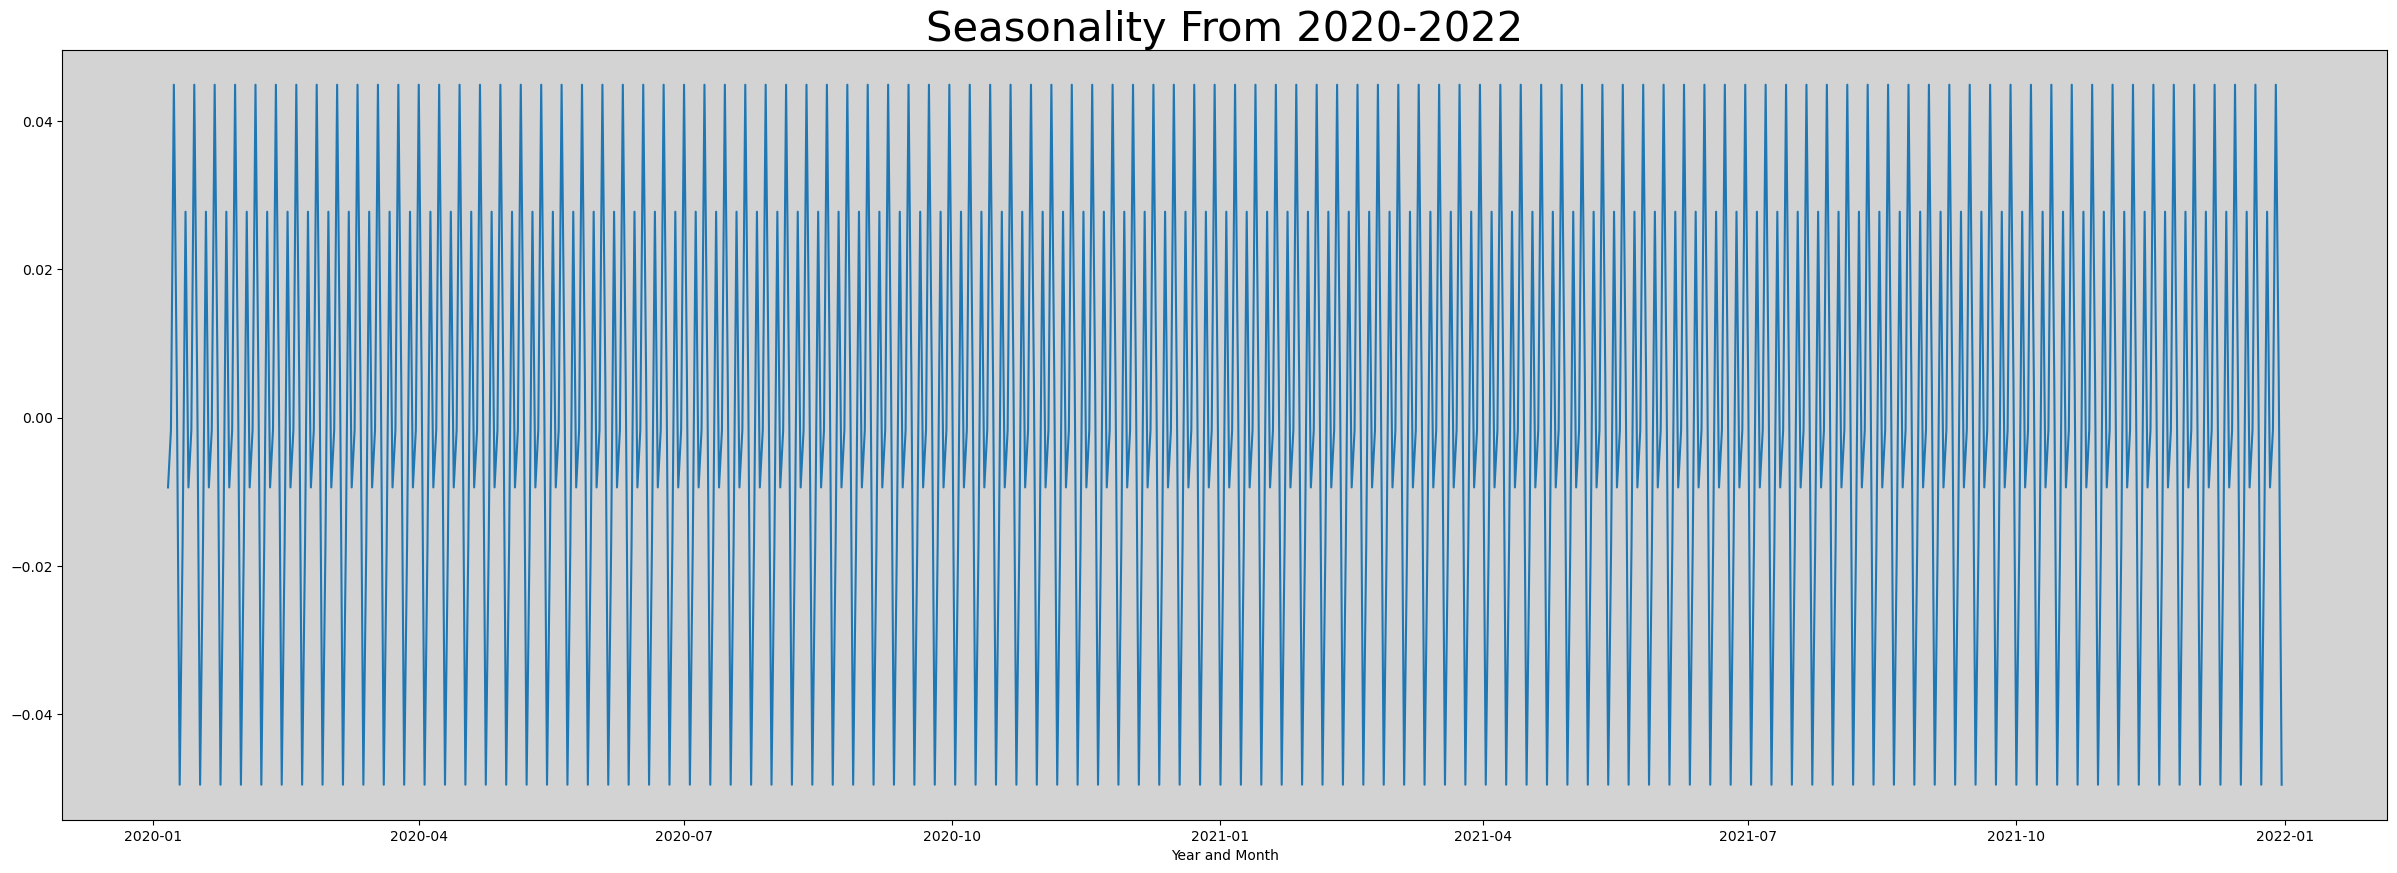

In [24]:
seasonal_decomp = seasonal_decompose(med_stationary_df['Revenue'])

#Plot the data.

# Show a graph of the seasonal decomposed data. 
plt.figure(figsize=[30, 10])
ax= plt.axes()
plt.rcParams.update({'font.size': 25})
plt.xlabel("Year and Month")
plt.title("Seasonality From 2020-2022")
ax.set_facecolor('lightgrey')

# Plot the seasonal component of the data.
plt.plot(seasonal_decomp.seasonal)

Reviewing the graph above we can see that there is a very marginal degree of seasonality.  This is indicated by the very small value of +0.04 or -0.06.  There is a need to look at this data in closer detail by looking at a small section of the data. This is also to look to see if there is any noise in the graph that may be affecting the seasonality of the data.  The next graph will look at a small chunk of the data.  Looking from February 1, 2020 to March 30, 2020.

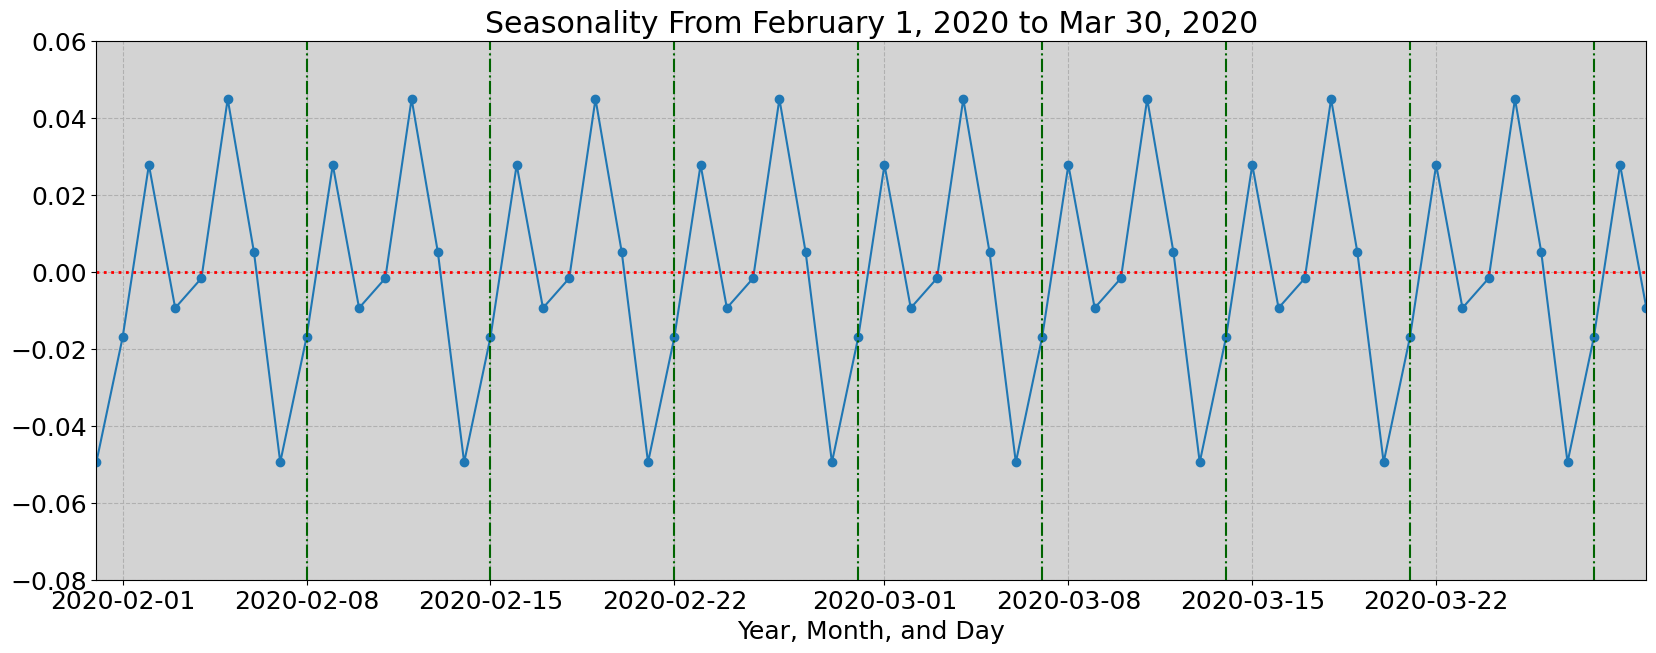

In [25]:
plt.figure(figsize=[20, 7])
plt.rcParams.update({'font.size': 18})

ax = plt.axes()

plt.xlabel("Year, Month, and Day")
plt.title("Seasonality From February 1, 2020 to Mar 30, 2020")

plt.ylim(-0.08, 0.06)
plt.xlim(pd.to_datetime('2020-01-31'), pd.to_datetime('2020-03-30'))
plt.grid(linestyle='--')

ax.set_facecolor('lightgrey')
plt.plot(seasonal_decomp.seasonal, marker='o')

plt.axhline(y=0, linewidth=2, linestyle=':',color='r')
plt.axvline(x=pd.to_datetime('2020-02-08'), color='darkgreen', linestyle='dashdot')

plt.axvline(x=pd.to_datetime('2020-02-15'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-02-22'), color='darkgreen', linestyle='dashdot')

plt.axvline(x=pd.to_datetime('2020-02-29'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-07'), color='darkgreen', linestyle='dashdot')

plt.axvline(x=pd.to_datetime('2020-03-14'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-21'), color='darkgreen', linestyle='dashdot')
plt.axvline(x=pd.to_datetime('2020-03-28'), color='darkgreen', linestyle='dashdot')

Looking at the smaller interval it is apparent that the data even after differencing still shows some seasonality. This is evident by the same pattern showing up throughout the time interval. This can be inferred by looking at the data cycles between the green vertical lines.  This would happen if you take the same amount of days.  In the case of this graph, it was seven days.  However, the value that was discussed previously is very small and should have little to no effect on the modeling process going forward. 

### 3. Check for trends.

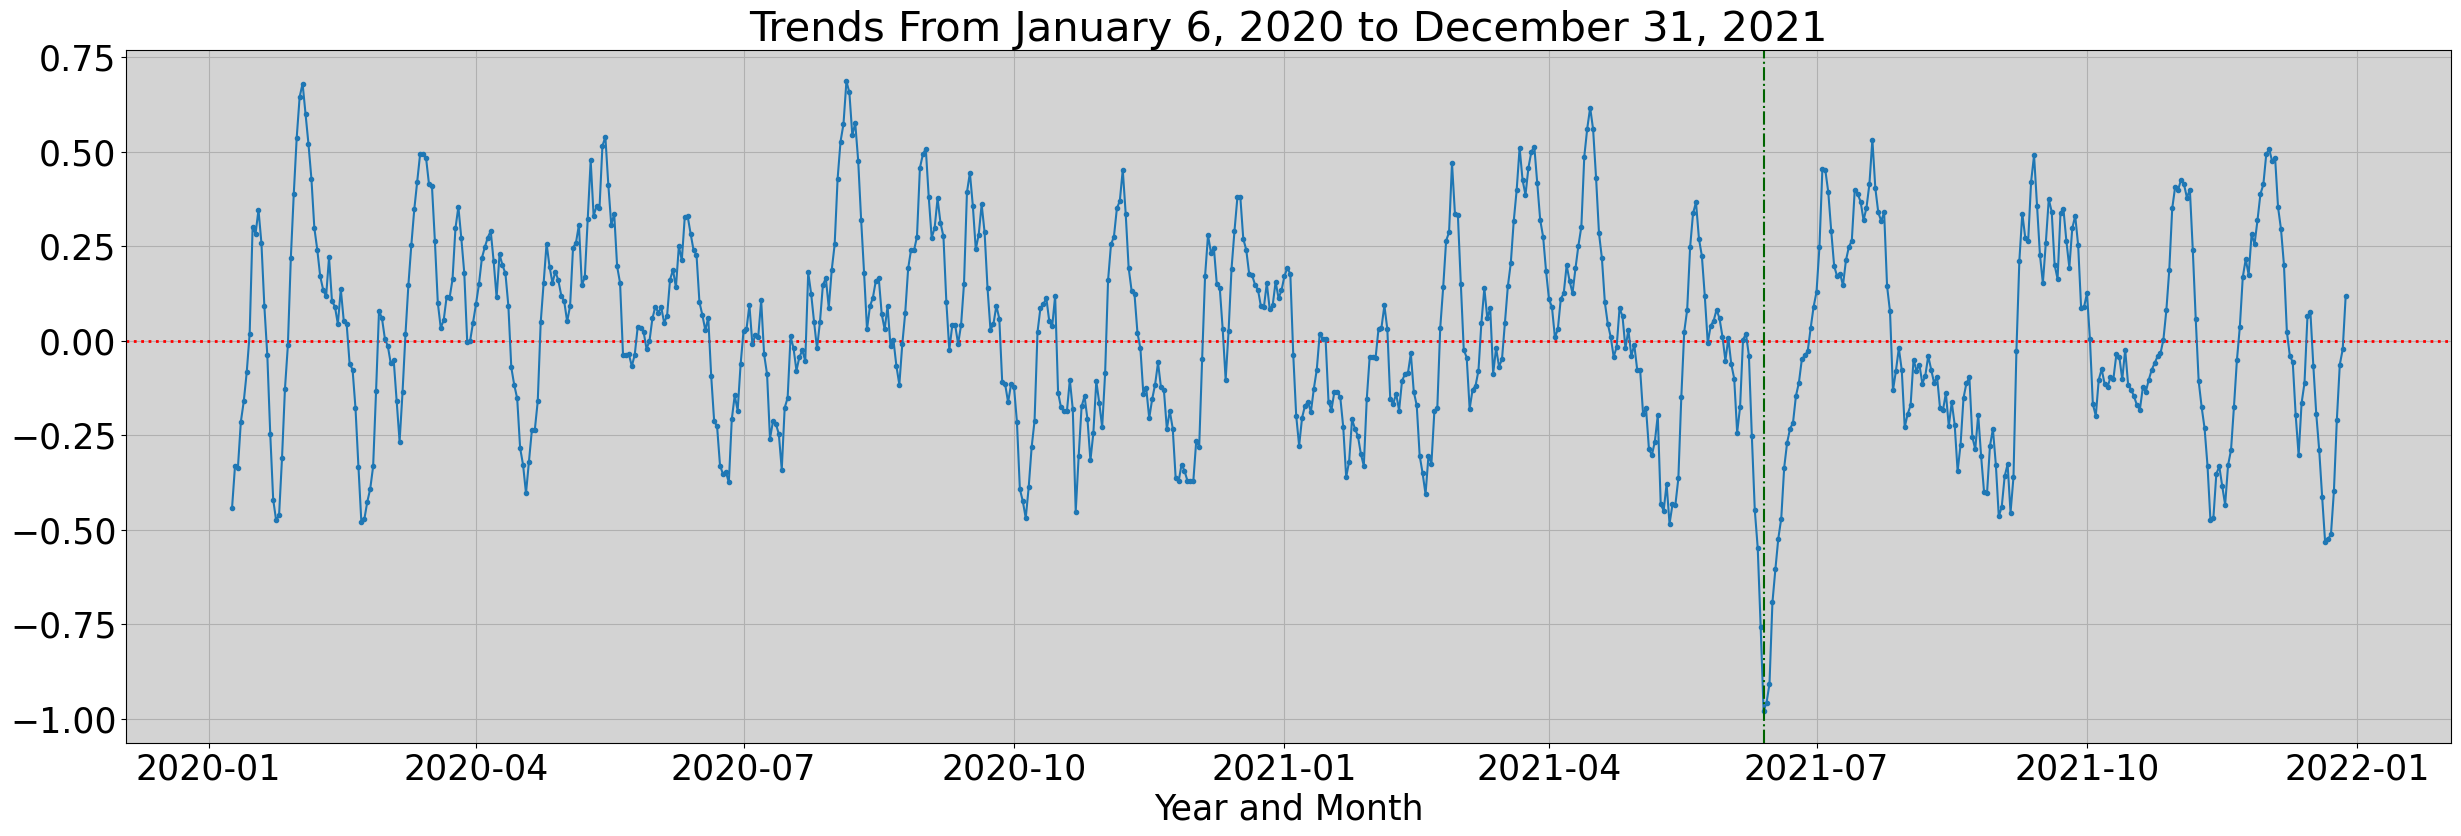

In [26]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=[30, 9])

ax = plt.axes()
ax.set_facecolor('lightgrey')

plt.xlabel("Year and Month")
plt.title("Trends From January 6, 2020 to December 31, 2021")

plt.axhline(y=0, linewidth=2, linestyle=':',color='r')
plt.plot(seasonal_decomp.trend, marker='.')
plt.axvline(x=pd.to_datetime('2021-06-13'), color='darkgreen', linestyle='dashdot')

plt.grid()

Based on the graph above, there does not seem to be any discernible pattern in the dataset. There is a noticeable drop in revenue around June 13th of 2021 (see green vertical line).This dip may be considered an outlier in the dataset. As it seems to be well outside of the range of the other revenue values.

In [27]:
med_stationary_df.sample(5 ,random_state=247)

Revenue  rolling_mean  rolling_std
Date                                           
2021-05-27 -0.234087      0.020187    -0.035103
2021-01-30 -0.582951     -0.157777     0.151735
2021-12-02  0.133058      0.533891     0.052810
2020-03-19  0.508440      0.464098     0.122472
2021-02-27  0.413669      0.169650     0.196861

In [28]:
#med_stationary_df.info() 

### 4. The Autocorrelation Function.

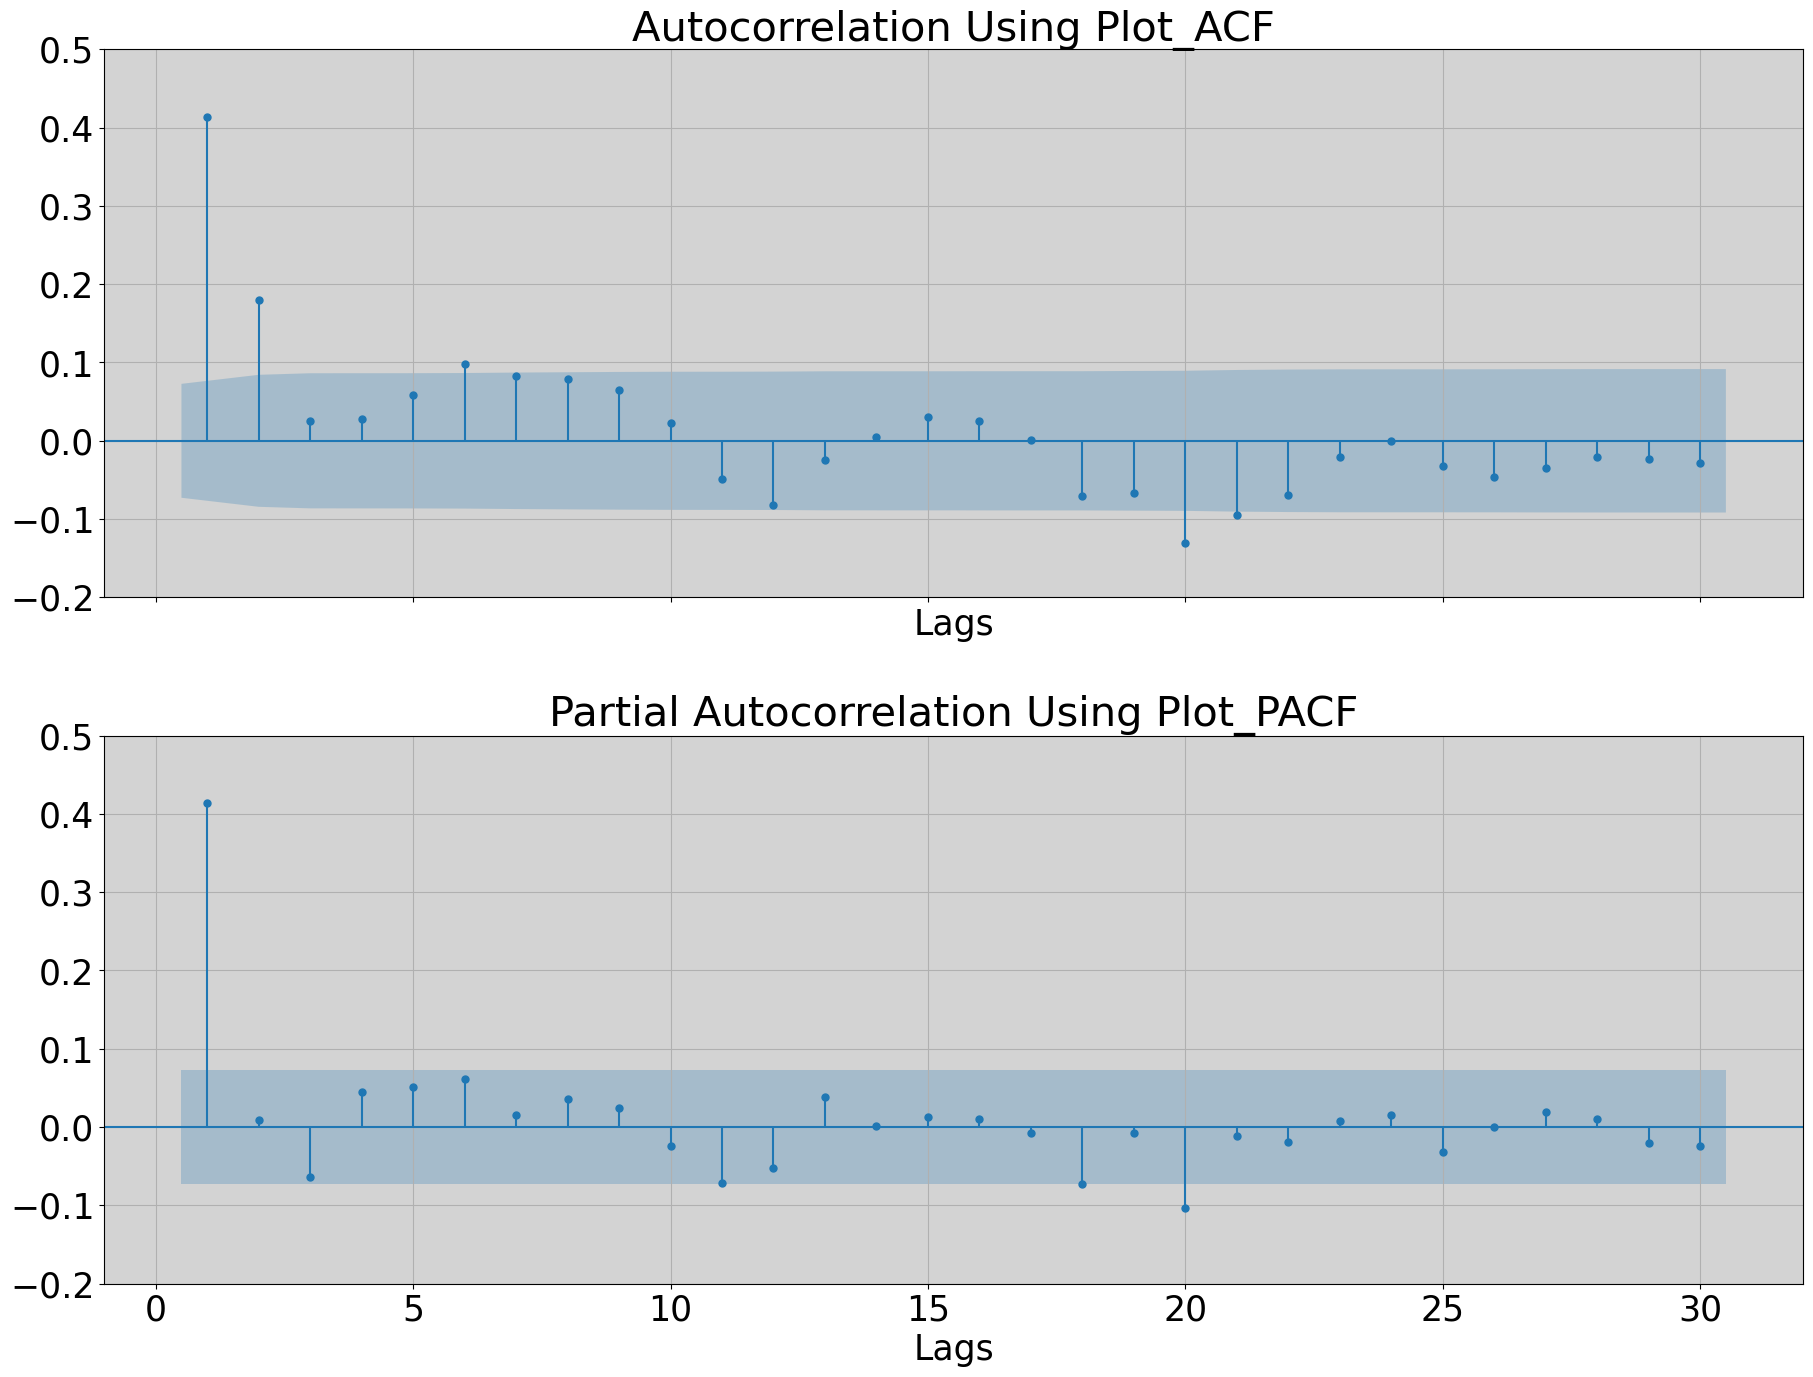

In [29]:
# Plot the auto correlation

lag = 30

fig, (ax,ax2) = plt.subplots(2,1, figsize=[20,15], sharex=True)
fig.tight_layout(pad=3.0)


# Plot the ACF graph.
plot_acf(med_stationary_df['Revenue'], lags=lag, zero=False
         , title="Autocorrelation Using Plot_ACF", ax=ax)
ax.set_ylim((-.20, 0.50))
ax.set_xlabel("Lags")
ax.set_facecolor("lightGray")
ax.grid()

#Plot the PACF graph.
plot_pacf(med_stationary_df['Revenue'], lags=lag, zero=False
         , title="Partial Autocorrelation Using Plot_PACF", ax=ax2)
ax2.set_xlabel("Lags")
ax2.set_facecolor("lightGray")
ax2.set_ylim((-.20, 0.50))
ax2.grid()

Plot both ACF and PACF for comparison of the values.  Plotted together to make it easier to show the values change in respect to each other

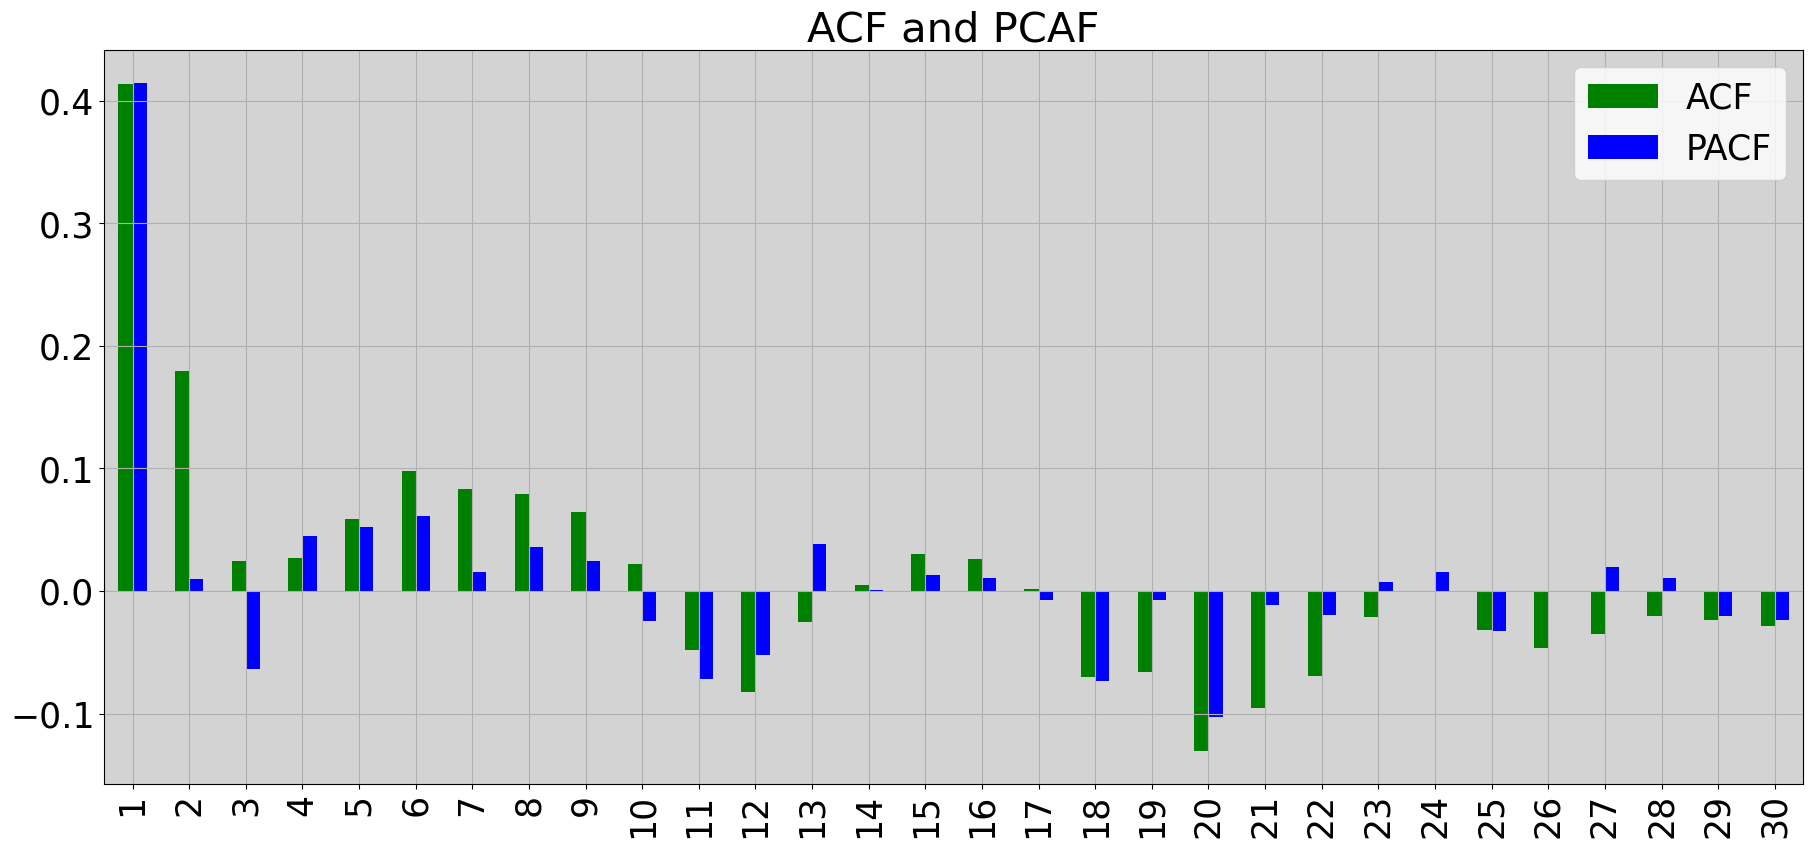

In [30]:
# Plot both on the same graph for comparison.#################################
# (statsmodels.tsa.stattools.pacf - Statsmodels 0.15.0 (+200), n.d.)
# (statsmodels.tsa.stattools.acf - Statsmodels 0.14.1, n.d.)

revenue_acf_df = acf(med_stationary_df['Revenue'], nlags=lag, missing='drop')

# Will use the default Yule-Walker. 
revenue_pacf_df = pacf(med_stationary_df['Revenue'], nlags=lag) 

# Create a pandas dataframe to hold the data from the correlation.
acf_pacf_df = pd.DataFrame([revenue_acf_df, revenue_pacf_df]).T

# Set the columns
acf_pacf_df.columns = ['ACF','PACF']
acf_pacf_df.drop(index=0, inplace=True)

fig, ax = plt.subplots(1,1, figsize=[20, 10], sharex=True)
fig.tight_layout(pad=3.0)

ax = acf_pacf_df.plot(kind='bar', color=('green', 'blue')
                      , title="ACF and PCAF", ax=ax)
ax.set_facecolor("lightGray")
ax.grid()

### 5. Spectral density.  

Create a spectral density plot of the data.

<AxesSubplot:title={'center':'Stationary Data'}>

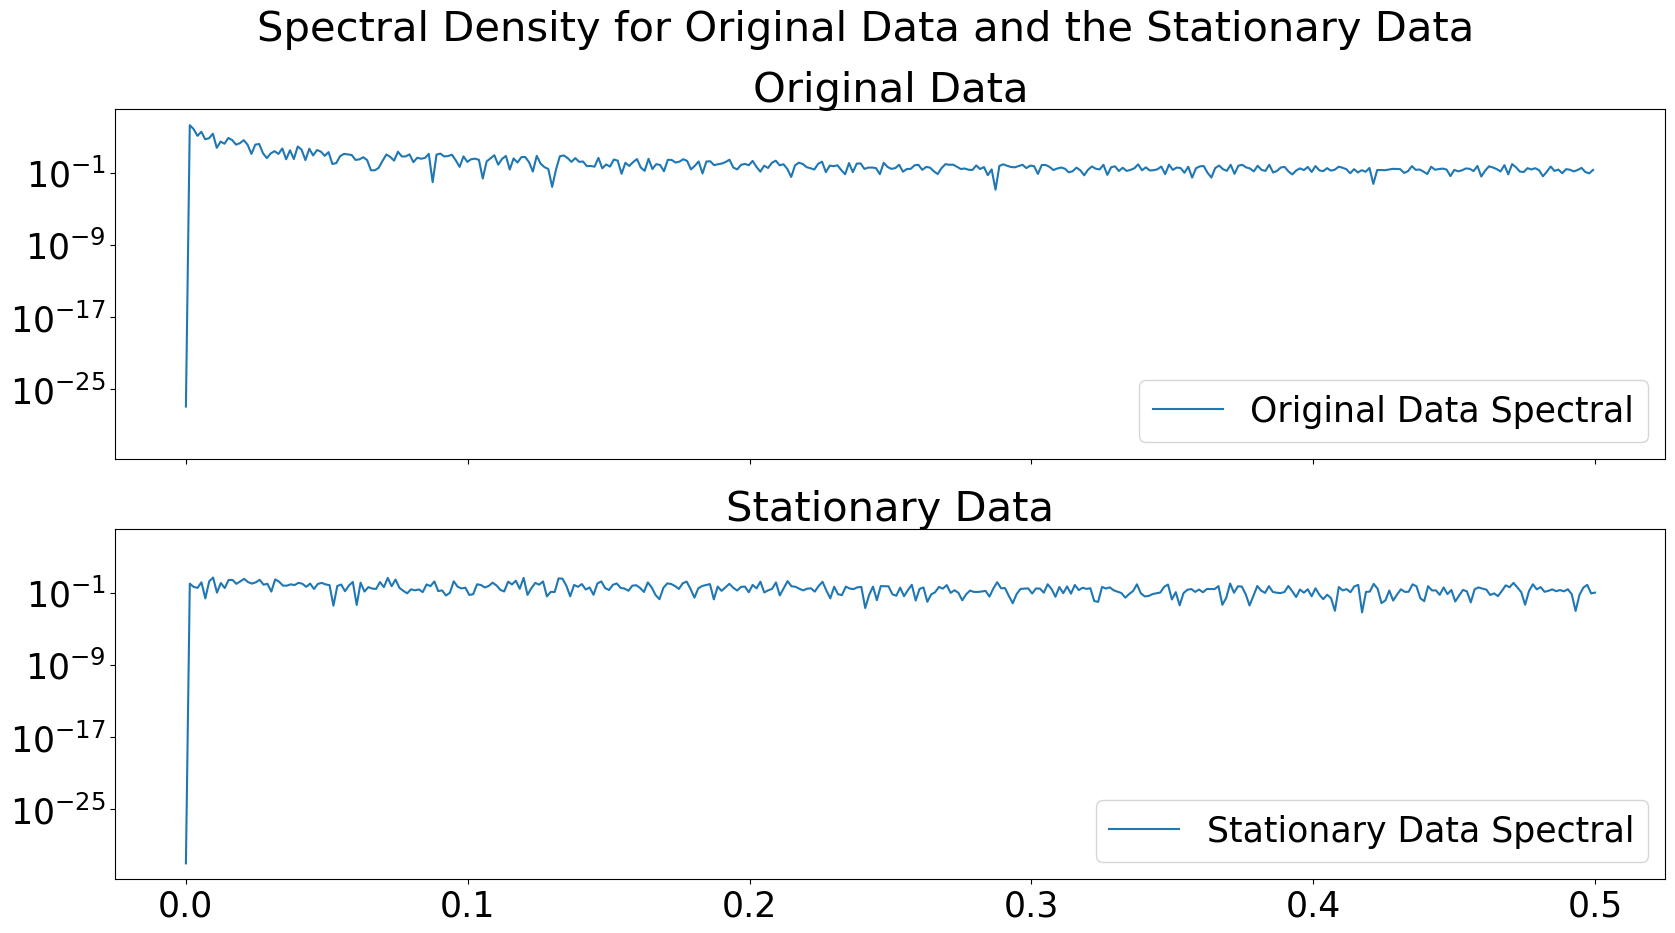

In [31]:
# Create a spectral density plot. Using a periodogram.
fig,ax = plt.subplots(2,1, figsize=(20,10), sharex=True, sharey=True)
fig.suptitle('Spectral Density for Original Data and the Stationary Data', fontsize=30)

# Create a plot for the first set of data the initial dataframe.
create_spectral_plt(dataframe=time_series_df,ax=ax, column='Revenue'
                    ,i=0, graph_title='Original Data'
                    , legend_text='Original Data Spectral')

create_spectral_plt(dataframe=med_stationary_df,ax=ax, column='Revenue'
                    ,i=1, graph_title='Stationary Data'
                    , legend_text='Stationary Data Spectral')


Plot using the PSD function available in the matplotlib.  This is done for mainly for comparison.

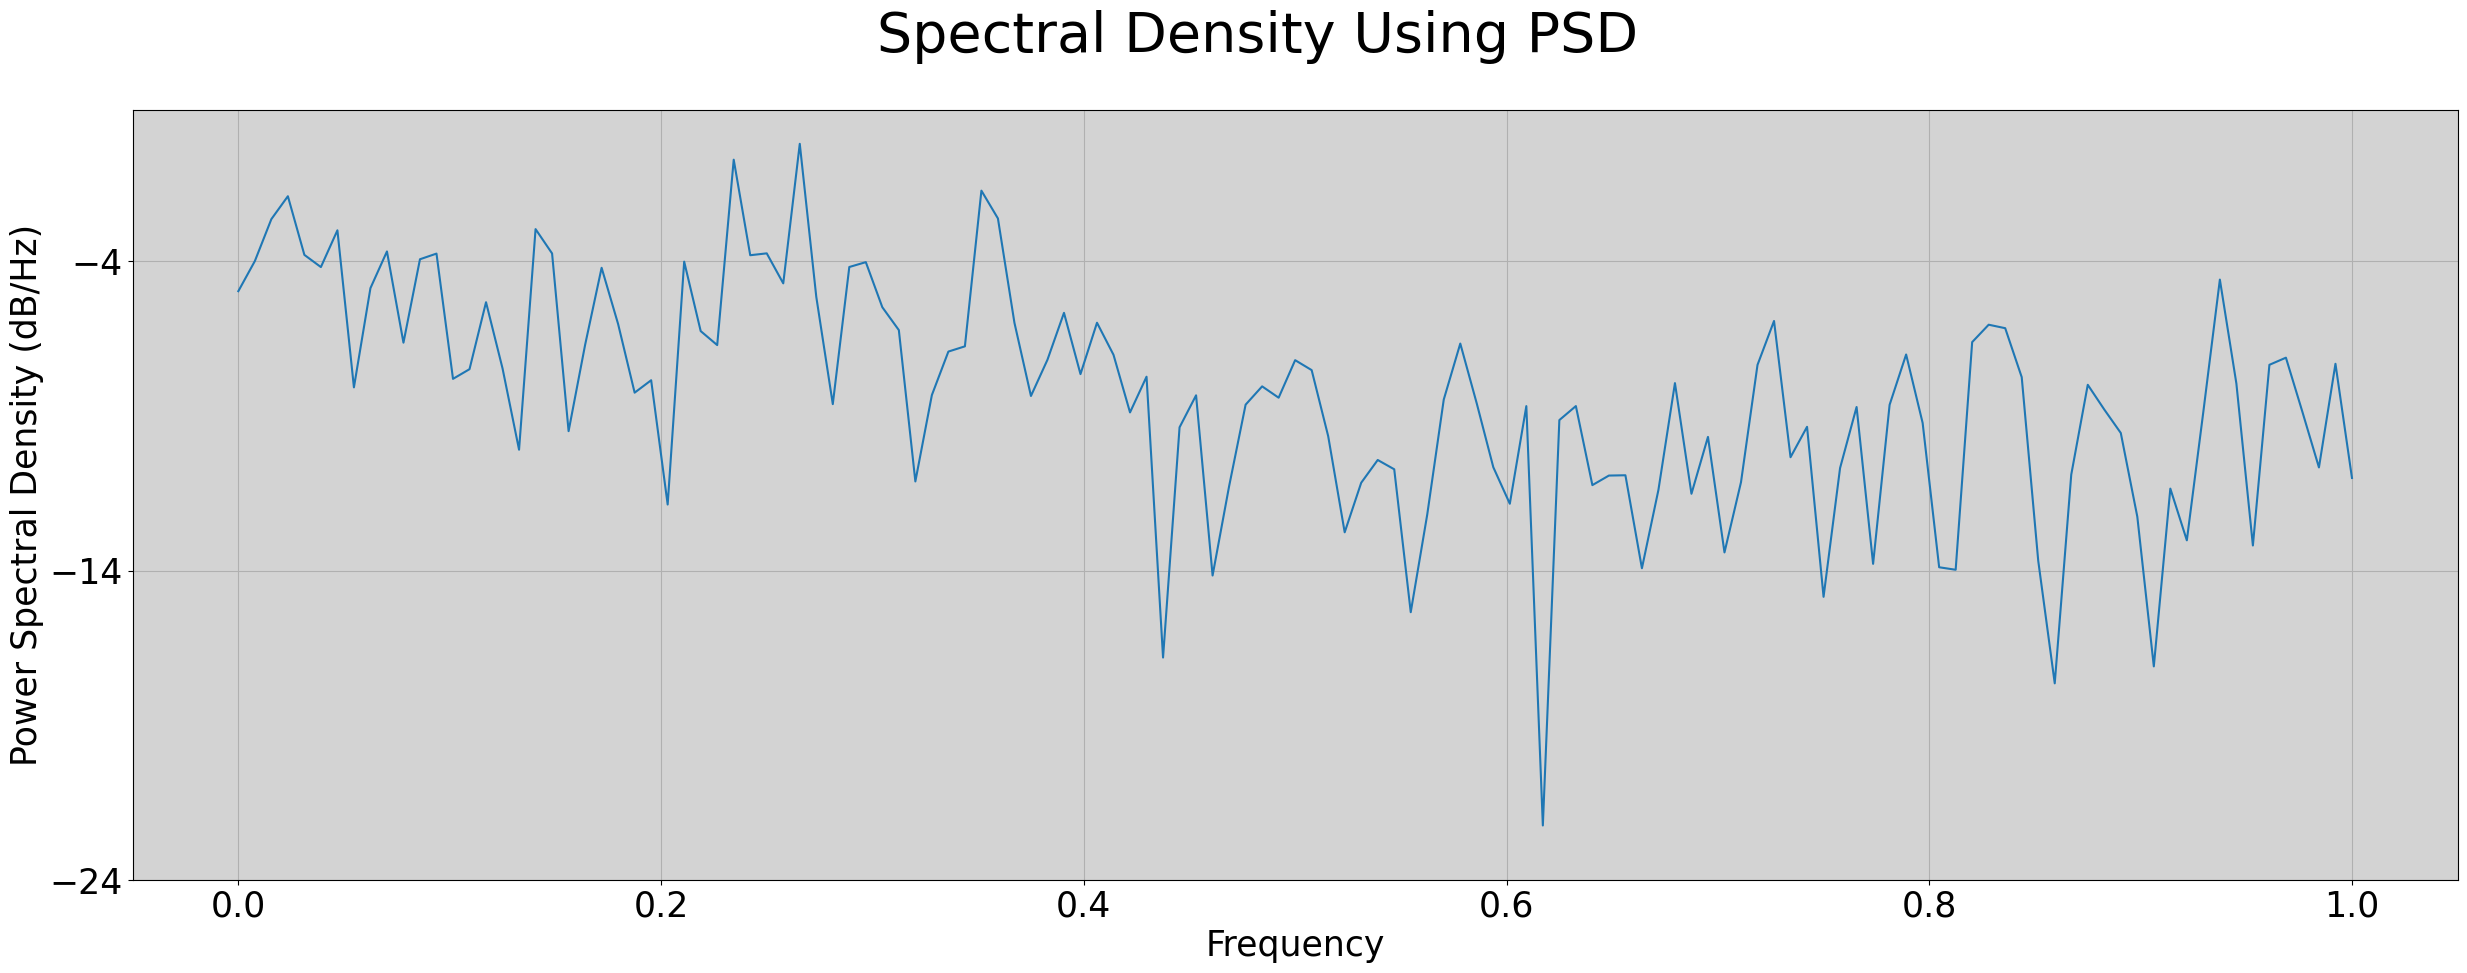

In [32]:
# Using the matplot version to view the spectral density graph of the 
# stationary data.
fig,ax = plt.subplots(1,1, figsize=(30,10))
fig.suptitle('Spectral Density Using PSD', fontsize=40)
ax.set_facecolor('lightgrey')
psd = plt.psd(x=med_stationary_df.Revenue)

### 6. The Decomposed Time Series.

This section shows a visual of the decomposed data.  It makes use of the **plot()**.

Text(0.5, 1.0, 'The Decomposed Time Series')

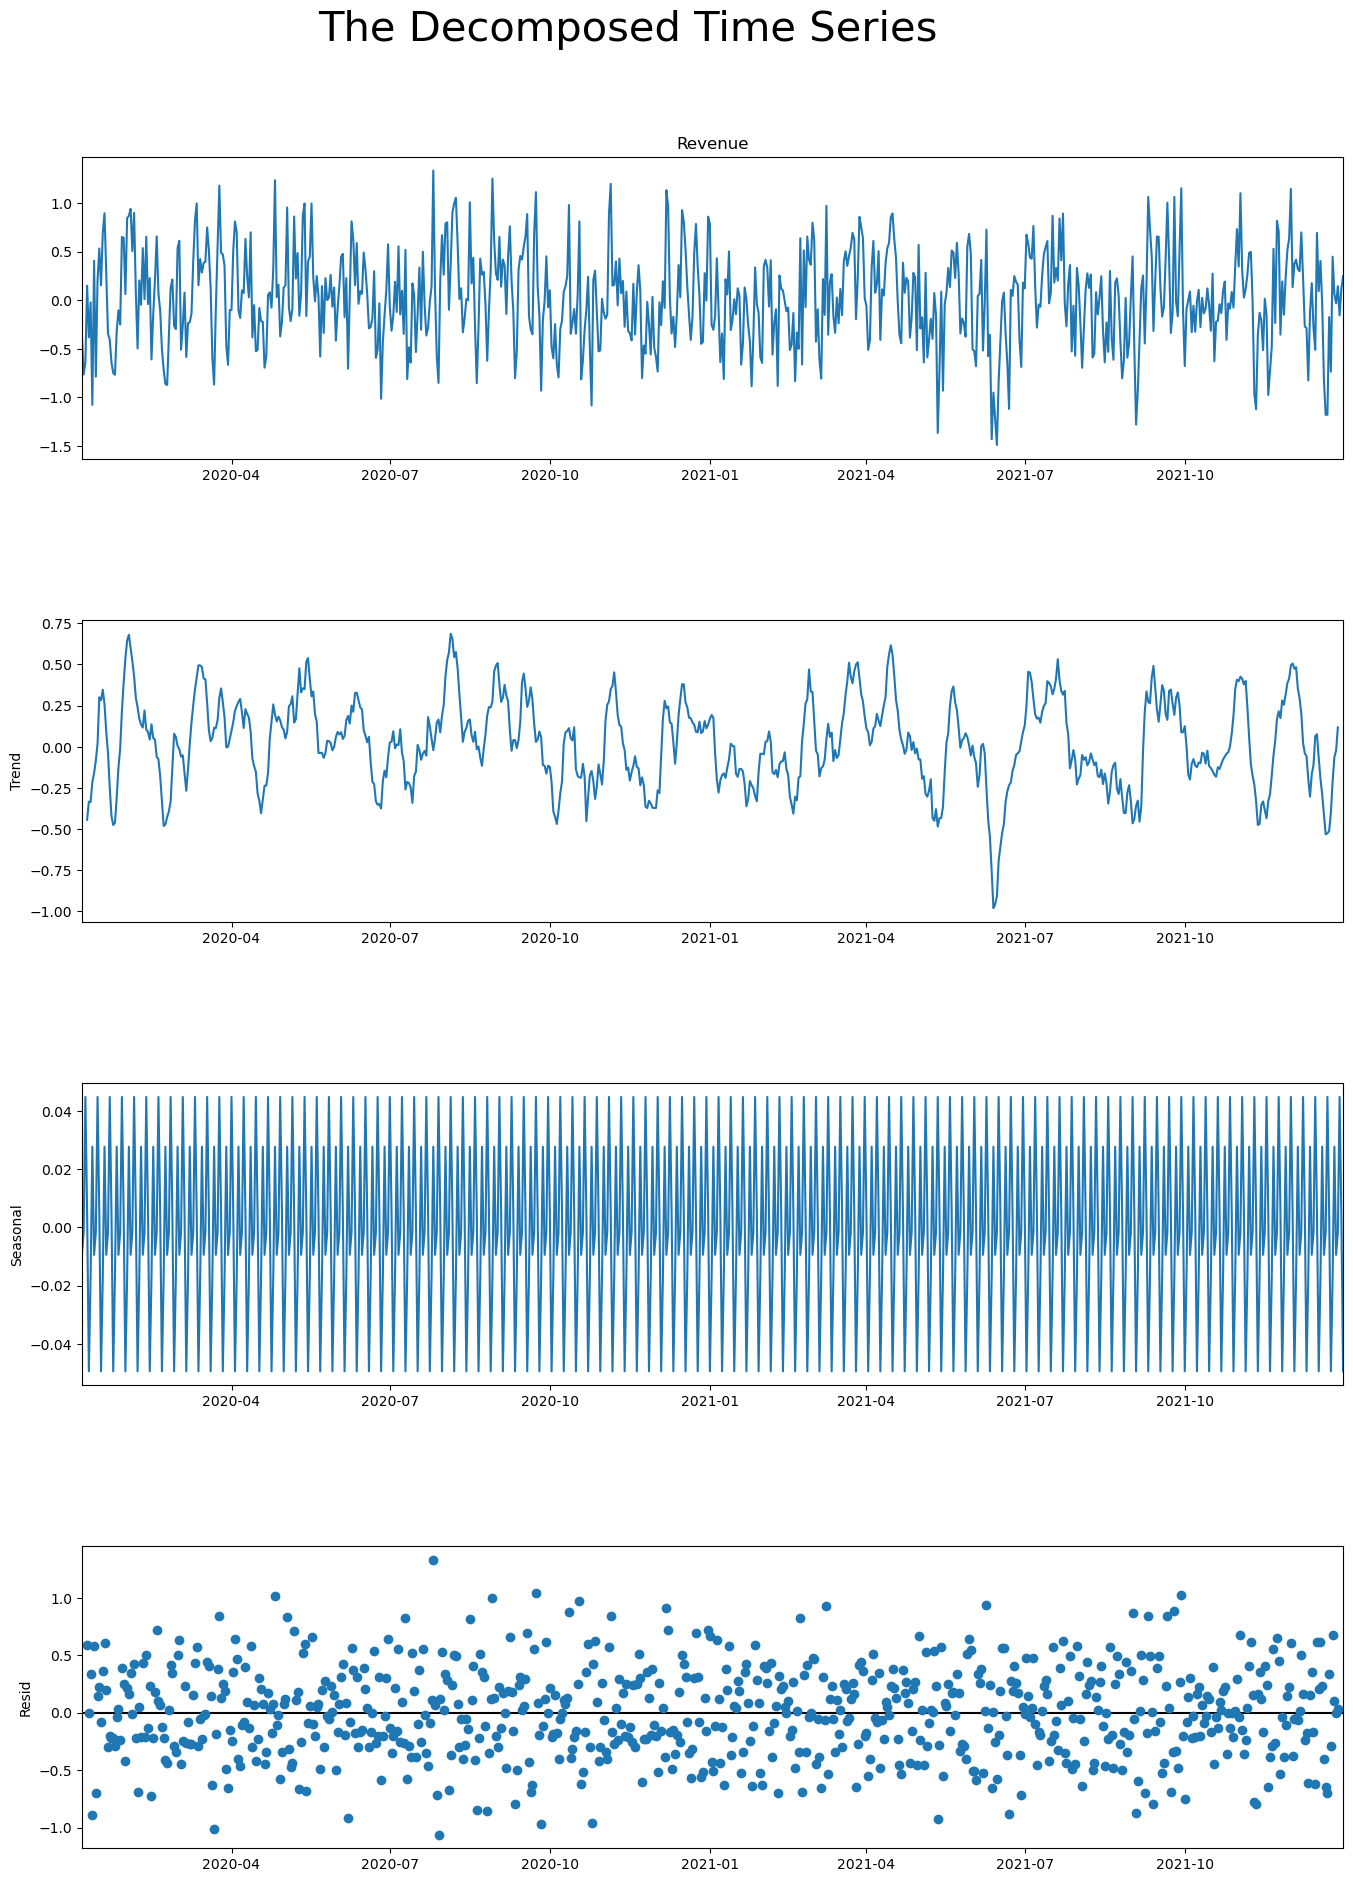

In [33]:
plt.rcdefaults()

newplot = seasonal_decomp.plot()
newplot.set_figwidth(15)
newplot.set_figheight(20) 
newplot.suptitle('The Decomposed Time Series', fontsize=30, y=1.0 )

### 7.  Lack of Trends in the Residuals of the Decomposed Time Series.

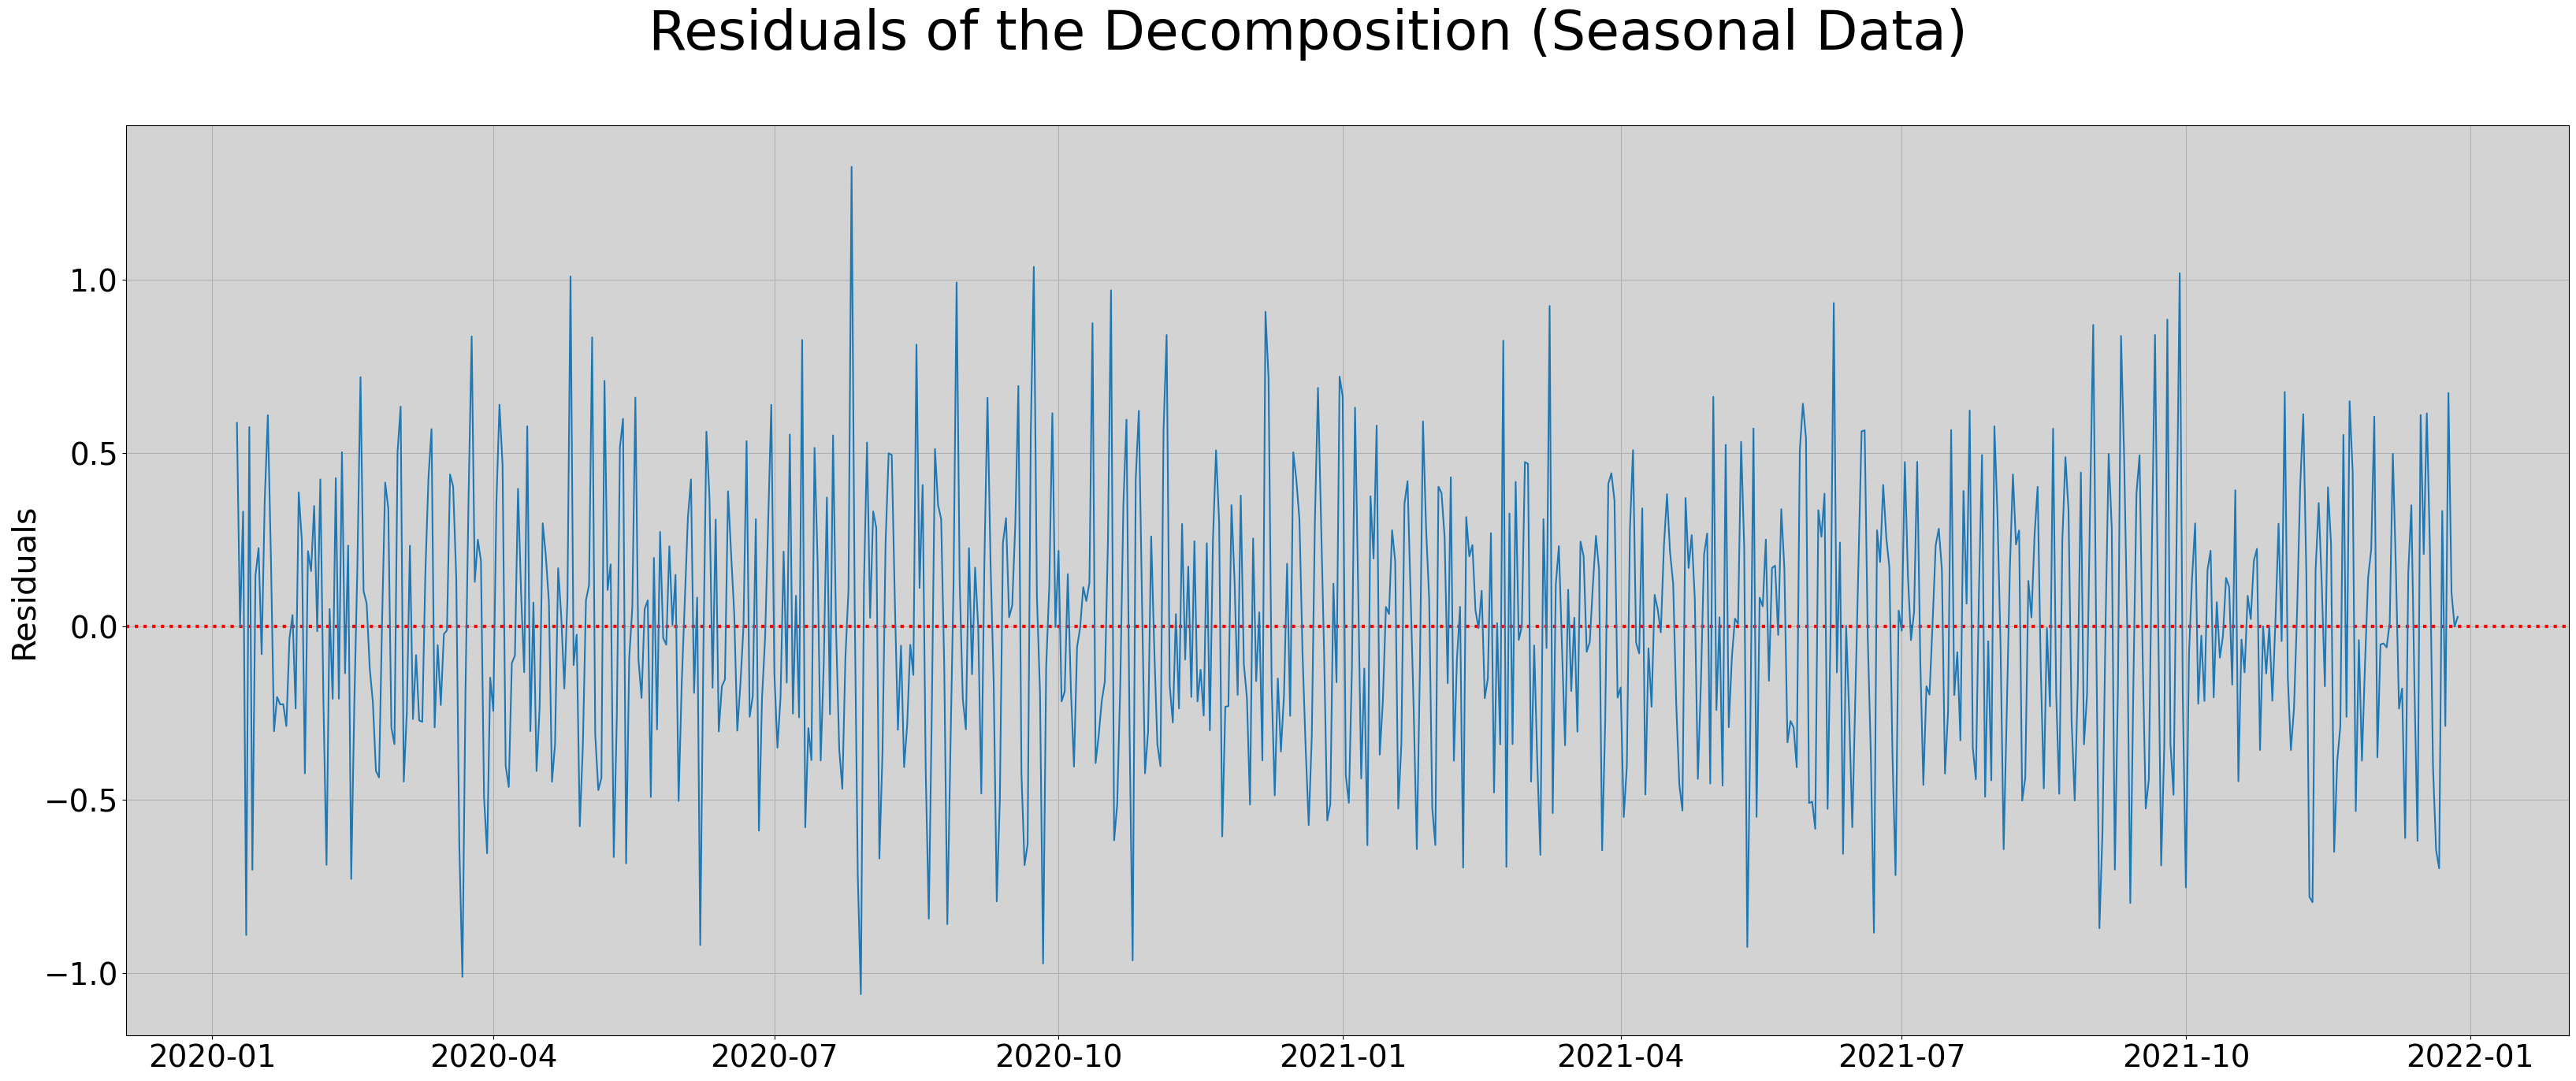

In [34]:
fig,ax = plt.subplots(1,1, figsize=(40,15))
fig.suptitle('Residuals of the Decomposition (Seasonal Data)', fontsize=50)

plt.axhline(y=0, linewidth=3, linestyle=':',color='r')
plt.ylabel("Residuals",fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.grid()
ax.set_facecolor("lightgrey")
plt.plot(seasonal_decomp.resid) 

## D2. Identification of ARIMA model.

In this section, the ARIMA model will be created.  The first attempt will use auto ARIMA using the  **auto_arima** from the **pmdarima** library. This method will try to find the optimal setting to use in creating the model  (Pulagam, 2021).

In [35]:
#Identification of ARIMA model.
pmd_auto_arima = auto_arima(train_df['Revenue'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=847.047, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.824, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=845.079, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=867.928, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=972.766, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=847.071, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=847.073, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=847.066, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=843.938, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=845.924, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=845.927, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=867.209, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=845.897, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.771 seconds


**Print the auto ARIMA summary.**

In [36]:
# print the summary for auto arima.
pmd_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  701
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -419.969
Date:                Mon, 12 Feb 2024   AIC                            843.938
Time:                        00:06:40   BIC                            853.040
Sample:                             0   HQIC                           847.456
                                - 701                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.035     11.863      0.000       0.346       0.483
sigma2         0.1943      0.011     17.535      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.94   Prob(JB):                         0.43
Heteroskedasticity (H):               0.99   Skew:                            -0.02
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Note:** This is to see the results of using the auto ARIMA results in this model.  This model will be used to make any predictions going forward.

### Create the model for the data using the parameters found by the **auto_arima** function

In [37]:
arima_model = ARIMA(time_series_df['Revenue'], order=(1,1,0))

# Fit the model.
model_results = arima_model.fit()

In [38]:
# print the model summary.
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -437.991
Date:                Mon, 12 Feb 2024   AIC                            879.982
Time:                        00:06:40   BIC                            889.168
Sample:                    01-01-2020   HQIC                           883.526
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3. Forecast using the ARIMA model.

In this section there will an attempt to make a forecast or prediction using the model that was created in the previous section. The model will use the following parameters (Brownlee, 2023):

- 1 = order of the autoregression model
- 1 = order of differencing
- 0 = the moving average term

These were the parameters that were suggested in the previous section using the **auto_arima** method, and may not be what will be encountered using trial-and-error method to arrive at these values. Further detail will be given in the Word document that accompanies this Notebook. The values will be used in the order argument of the ARIMA model.  The creation of the model will be done in the next code cell.

### Make a 30 day forecast.

In [39]:
# Make a 30 day forecast.
print("\nForecast: \n\n",model_results.forecast(30))

model_forecasts_30 = model_results.forecast(steps=30)  # New into the future.

#print(model_forecasts_30)


Forecast: 

 2022-01-01    16.171559
2022-01-02    16.213862
2022-01-03    16.231384
2022-01-04    16.238642
2022-01-05    16.241649
2022-01-06    16.242894
2022-01-07    16.243410
2022-01-08    16.243623
2022-01-09    16.243712
2022-01-10    16.243749
2022-01-11    16.243764
2022-01-12    16.243770
2022-01-13    16.243773
2022-01-14    16.243774
2022-01-15    16.243774
2022-01-16    16.243774
2022-01-17    16.243774
2022-01-18    16.243774
2022-01-19    16.243774
2022-01-20    16.243774
2022-01-21    16.243774
2022-01-22    16.243774
2022-01-23    16.243774
2022-01-24    16.243774
2022-01-25    16.243774
2022-01-26    16.243774
2022-01-27    16.243774
2022-01-28    16.243774
2022-01-29    16.243774
2022-01-30    16.243774
Freq: D, Name: predicted_mean, dtype: float64


Review the last 30 days of data in the original dataframe.

In [40]:
time_series_df.tail(30)

Revenue  rolling_mean  rolling_std
Date                                            
2021-12-02  17.970498     16.820017     1.071481
2021-12-03  18.343148     17.380666     0.962014
2021-12-04  18.760310     17.920868     0.774630
2021-12-05  19.080317     18.398343     0.523646
2021-12-06  19.378591     18.706573     0.563042
2021-12-07  20.076182     19.127710     0.654848
2021-12-08  20.307137     19.520507     0.655623
2021-12-09  20.035505     19.775546     0.519968
2021-12-10  19.750009     19.909484     0.356748
2021-12-11  18.925067     19.818780     0.537394
2021-12-12  18.803687     19.564281     0.669977
2021-12-13  18.978486     19.298551     0.555369
2021-12-14  18.694026     19.030255     0.417185
2021-12-15  18.184189     18.717091     0.317646
2021-12-16  18.875765     18.707231     0.310256
2021-12-17  18.968519     18.740197     0.331123
2021-12-18  19.372149     18.818930     0.433058
2021-12-19  19.338288     18.947782     0.479915
2021-12-20  18.512654     19.013475     0.355654
2021-12-21  17.333768     18.705076     0.841555
2021-12-22  16.155111     18.142394     1.385886
2021-12-23  15.981459     17.464256     1.461225
2021-12-24  15.246219     16.645842     1.284464
2021-12-25  15.693218     16.081955     0.779753
2021-12-26  15.754749     15.766151     0.344030
2021-12-27  15.722056     15.679540     0.267662
2021-12-28  15.865822     15.656413     0.238456
2021-12-29  15.708988     15.748966     0.069136
2021-12-30  15.822867     15.774896     0.067288
2021-12-31  16.069429     15.837832     0.145473

### Make predictions for the last 30 days of the data.

In [41]:
# Make pedictions for the last 30 days of the data.
model_predictions = model_results.predict(start=700, end=731, type='levels')

print(model_predictions)

2021-12-01    16.955407
2021-12-02    18.311505
2021-12-03    18.025613
2021-12-04    18.497504
2021-12-05    18.933104
2021-12-06    19.212868
2021-12-07    19.502139
2021-12-08    20.365132
2021-12-09    20.402801
2021-12-10    19.922991
2021-12-11    19.631753
2021-12-12    18.583366
2021-12-13    18.753410
2021-12-14    19.050890
2021-12-15    18.576199
2021-12-16    17.973008
2021-12-17    19.162225
2021-12-18    19.006939
2021-12-19    19.539338
2021-12-20    19.324263
2021-12-21    18.170665
2021-12-22    16.845458
2021-12-23    15.666896
2021-12-24    15.909530
2021-12-25    14.941674
2021-12-26    15.878371
2021-12-27    15.780235
2021-12-28    15.708514
2021-12-29    15.925371
2021-12-30    15.644025
2021-12-31    15.870038
2022-01-01    16.171559
Freq: D, Name: predicted_mean, dtype: float64


In [42]:
get_forecasts = model_results.get_forecast(30)

y_hat = get_forecasts.predicted_mean
conf_int = get_forecasts.conf_int(alpha=0.05)


In [43]:
print("\n\n\n Y_YHAT CONFIDENCE",type(conf_int))
print("\nContents of the y-hat conf: ", conf_int.head(30) )




 Y_YHAT CONFIDENCE <class 'pandas.core.frame.DataFrame'>

Contents of the y-hat conf:              lower Revenue  upper Revenue
2022-01-01      15.307544      17.035573
2022-01-02      14.717345      17.710378
2022-01-03      14.202382      18.260386
2022-01-04      13.755465      18.721819
2022-01-05      13.362594      19.120703
2022-01-06      13.011400      19.474387
2022-01-07      12.692498      19.794321
2022-01-08      12.399053      20.088194
2022-01-09      12.126106      20.361317
2022-01-10      11.870015      20.617482
2022-01-11      11.628052      20.859475
2022-01-12      11.398133      21.089407
2022-01-13      11.178631      21.308915
2022-01-14      10.968249      21.519298
2022-01-15      10.765940      21.721608
2022-01-16      10.570840      21.916708
2022-01-17      10.382231      22.105318
2022-01-18      10.199504      22.288045
2022-01-19      10.022141      22.465408
2022-01-20       9.849696      22.637853
2022-01-21       9.681781      22.805768
2022-01-

## D2.  A Visualization of the Predictions 

### Plot a graph of the predictions veruse the test data.

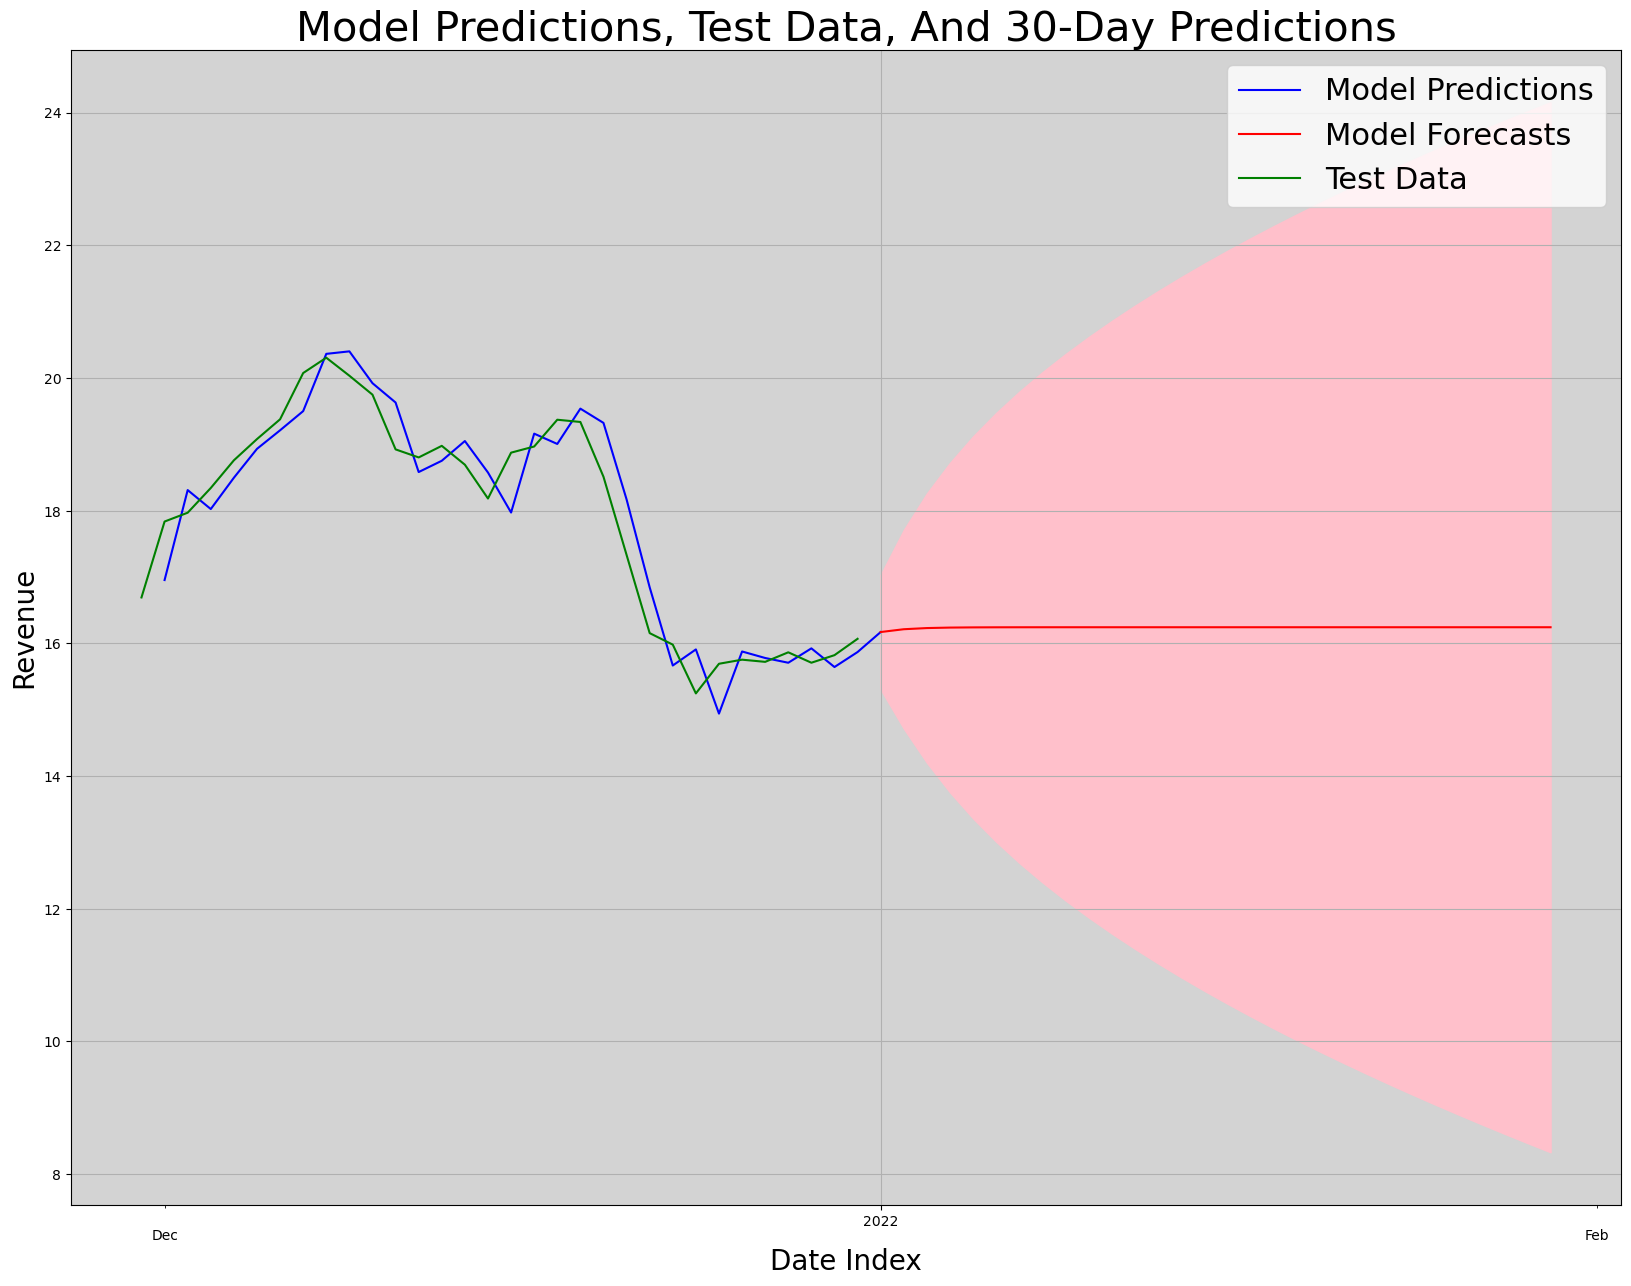

In [44]:
fig, ax = plt.subplots(1,1, figsize = (20, 15))
plt.rcParams.update({'font.size': 22})
predictions = plt.plot(model_predictions, "b", label='Model Predictions')

forecasts = plt.plot(model_forecasts_30, "r", label='Model Forecasts')   # new ******************


plt.fill_between(conf_int.index, conf_int['lower Revenue'], conf_int['upper Revenue'], color='pink') # new *****

plt.plot(test_df['Revenue'], "g", label='Test Data')
plt.xlabel("Date Index",fontsize=20)
plt.ylabel("Revenue",fontsize=20)
plt.title('Model Predictions, Test Data, And 30-Day Predictions',fontsize=30)

plt.legend()
plt.grid()

ax.set_facecolor('lightgrey')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%b'))


### Plot the Diagnostics of the model

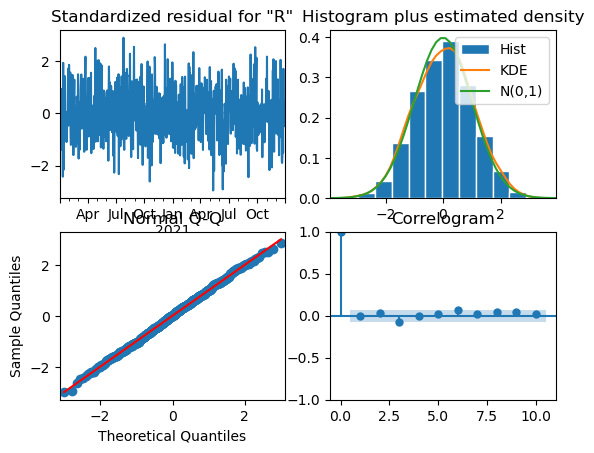

In [45]:
# Plot the Diagnostics of the model
plt.rcdefaults()

ax=model_results.plot_diagnostics()

### Look at the root mean square error(RMSE).

In [46]:
# Look at the root mean square error(RMSE).

rmse = sqrt(mean_squared_error(model_predictions, test_df['Revenue']))

In [47]:
print("Value of the RMSE: ", rmse)

Value of the RMSE:  0.21968551113004772


## All other sections.

The other sections that are required by the assessment can be found in the Word document that accompanies this Jupyter Notebook. Please refer to the Word document for these sections.  